In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   novara
   2   lecce
   3   macerata
   4   benevento
   5   messina
   6   treviso
   7   pordenone
   8   pavia
   9   bari
   10   varese
   11   matera
   12   crotone
   13   massa
   14   trieste
   15   fermo
   16   verona
   17   rimini
   18   monza
   19   catanzaro
   20   sondrio
   21   chieti
   22   cremona
   23   mantova
   24   alessandria
   25   siracusa
   26   salerno
   27   firenze
   28   l_aquila
   29   taranto
   30   padova
   31   terni
   32   enna
   33   milano
   34   reggio_di_calabria
   35   napoli
   36   asti
   37   udine
   38   potenza
   39   ragusa
   40   verbania
   41   pistoia
   42   trento
   43   ferrara
   44   pesaro
   45   brescia
   46   agrigento
   47   venezia
   48   grosseto
   49   livorno
   50   la_spezia
   51   ascoli_piceno
   52   avellino
   53   carbonia
   54   bolzano
   55   roma
   56   lodi
   57   torino
   58   caltanissetta
   59

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 novara
2 lecce
3 macerata
4 benevento
5 messina
6 treviso
7 pordenone
8 pavia
9 bari
10 varese
11 matera
12 crotone
13 massa
14 trieste
15 fermo
16 verona
17 rimini
18 monza
19 catanzaro
20 sondrio
21 chieti
22 cremona
23 mantova
24 alessandria
25 siracusa
26 salerno
27 firenze
28 l_aquila
29 taranto
30 padova
31 terni
32 enna
33 milano
34 reggio_di_calabria
35 napoli
36 asti
37 udine
38 potenza
39 ragusa
40 verbania
41 pistoia
42 trento
43 ferrara
44 pesaro
45 brescia
46 agrigento
47 venezia
48 grosseto
49 livorno
50 la_spezia
51 ascoli_piceno
52 avellino
53 bolzano
54 roma
55 lodi
56 torino
57 caltanissetta
58 lecco
59 bergamo
60 caserta
61 frosinone
62 arezzo
63 bologna
64 lucca
65 brindisi
66 pisa
67 parma
68 foggia
69 savona
70 ravenna
71 pescara
72 vercelli
73 rovigo
74 cosenza
75 vicenza
76 viterbo
77 cuneo
78 biella
79 sassari
80 catania
81 campobasso
82 trapani
83 genova
84 bat
85 cagliari
86 palermo
87 rieti
88 belluno
89 latina
90 ancona
91 forli
92 como
93 vibo_valentia
9

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

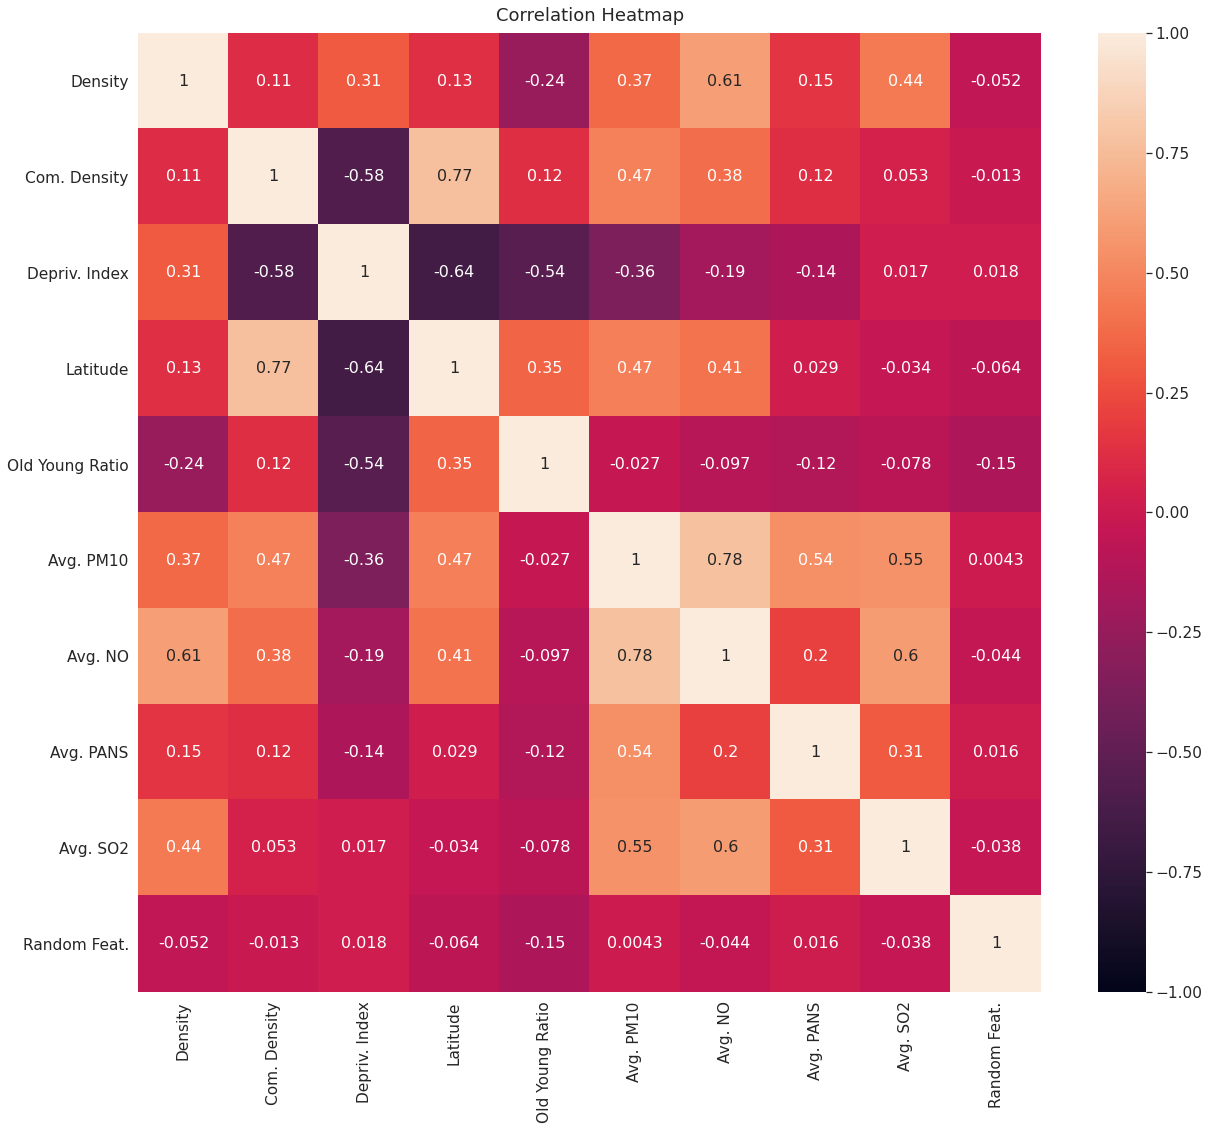

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34805  0.01888 
    Test set average RMSE:  0.92475  0.09278 

Prediction STD :    1.29587
True value STD :    1.47826
Difference in percentage:   12.33818

             Fullset RMSE:    0.33774
                       R2:    0.94780


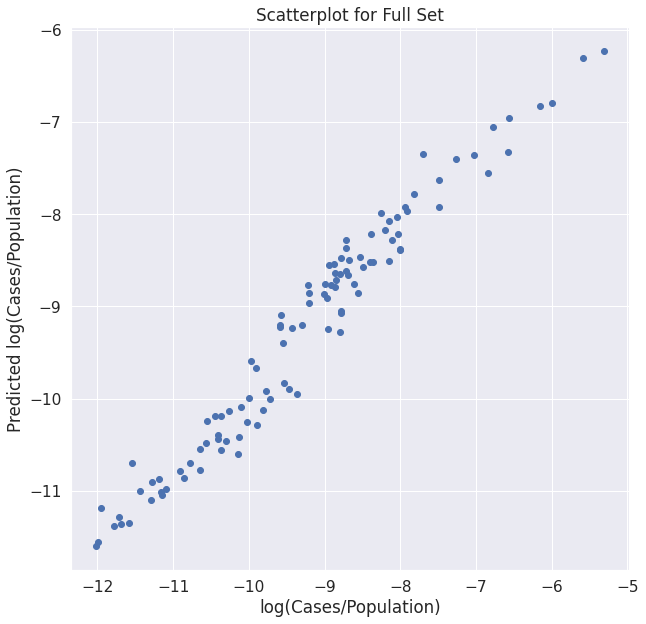

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05591 +/- 0.00559
Feature:                   Com. Density, Score: 0.25990 +/- 0.04310
Feature:                  Depriv. Index, Score: 0.11446 +/- 0.01319
Feature:                       Latitude, Score: 0.82476 +/- 0.10948
Feature:                Old Young Ratio, Score: 0.10675 +/- 0.01230
Feature:                      Avg. PM10, Score: 0.19442 +/- 0.02090
Feature:                        Avg. NO, Score: 0.23393 +/- 0.02498
Feature:                      Avg. PANS, Score: 0.05884 +/- 0.00599
Feature:                       Avg. SO2, Score: 0.08347 +/- 0.01037


<Figure size 432x288 with 0 Axes>

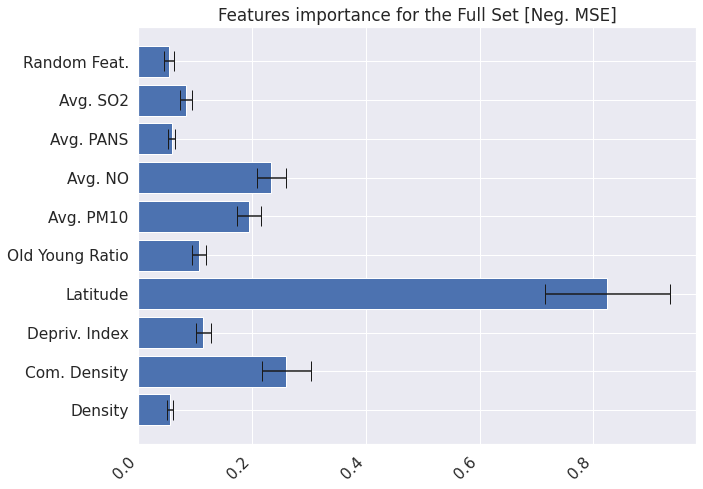

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02559 +/- 0.00256
Feature:                   Com. Density, Score: 0.11893 +/- 0.01972
Feature:                  Depriv. Index, Score: 0.05238 +/- 0.00603
Feature:                       Latitude, Score: 0.37742 +/- 0.05010
Feature:                Old Young Ratio, Score: 0.04885 +/- 0.00563
Feature:                      Avg. PM10, Score: 0.08897 +/- 0.00956
Feature:                        Avg. NO, Score: 0.10705 +/- 0.01143
Feature:                      Avg. PANS, Score: 0.02693 +/- 0.00274
Feature:                       Avg. SO2, Score: 0.03820 +/- 0.00475


<Figure size 432x288 with 0 Axes>

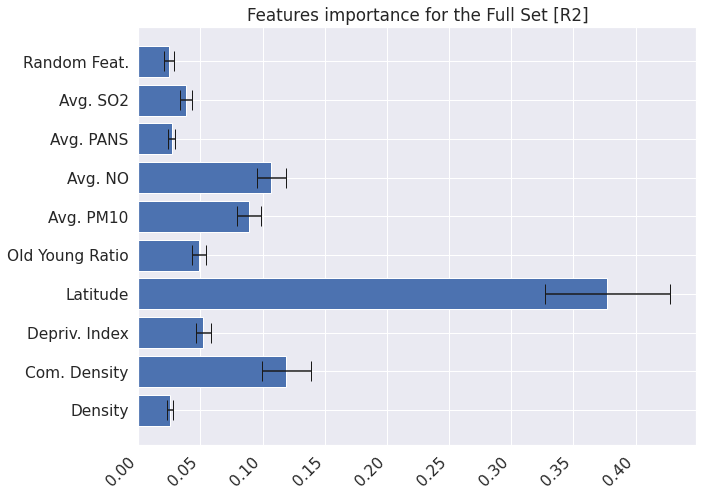

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.34020
                       R2:    0.94959


<Figure size 432x288 with 0 Axes>

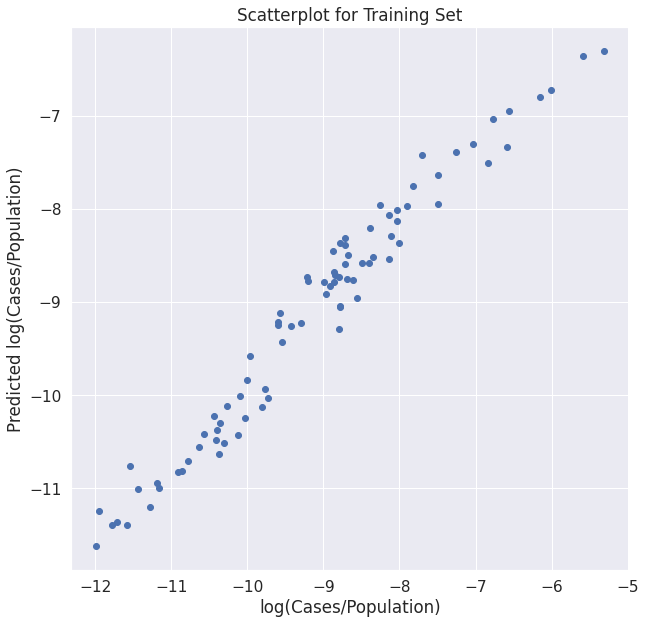

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.82601
                       R2:    0.50891


<Figure size 432x288 with 0 Axes>

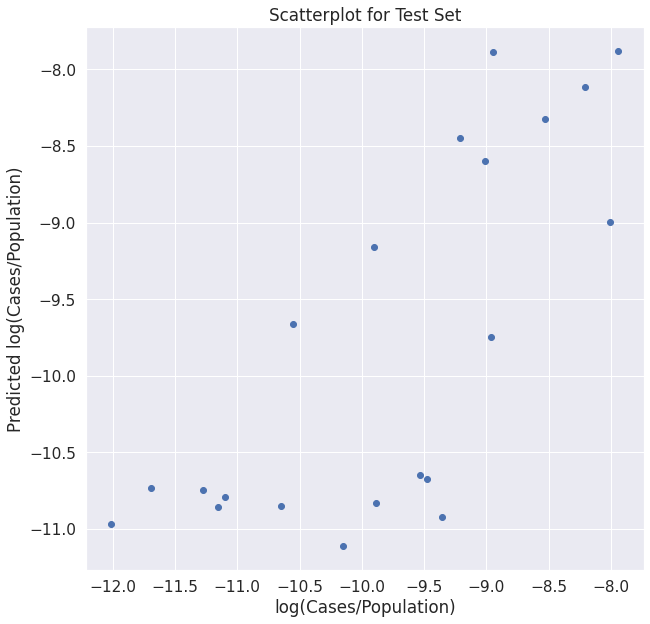

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.01446 +/- 0.02765
Feature:                       Latitude, Score: 0.39323 +/- 0.21385


<Figure size 432x288 with 0 Axes>

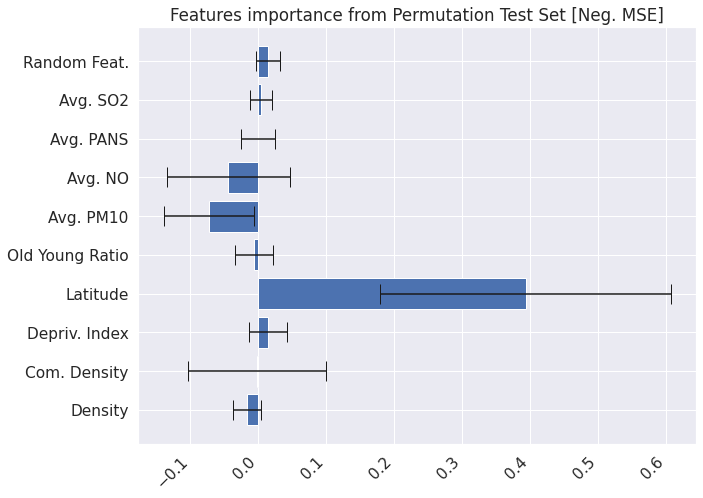

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.01041 +/- 0.01990
Feature:                       Latitude, Score: 0.28303 +/- 0.15392


<Figure size 432x288 with 0 Axes>

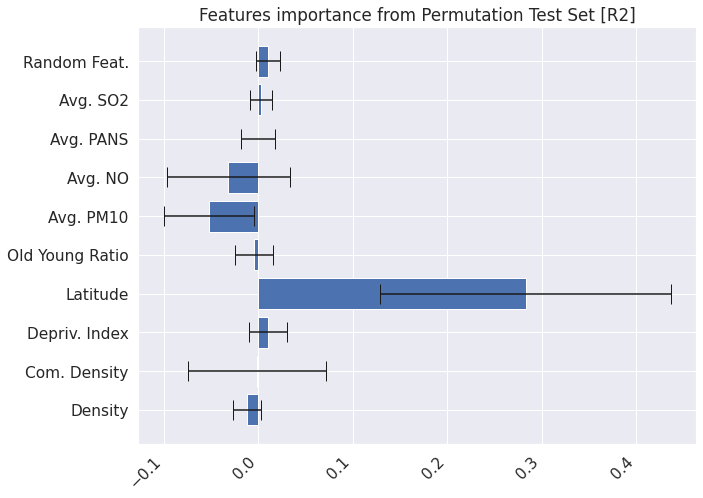

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06236 +/- 0.00669
Feature:                   Com. Density, Score: 0.26157 +/- 0.04385
Feature:                  Depriv. Index, Score: 0.08818 +/- 0.01219
Feature:                       Latitude, Score: 0.71540 +/- 0.10845
Feature:                Old Young Ratio, Score: 0.10571 +/- 0.01848
Feature:                      Avg. PM10, Score: 0.23363 +/- 0.03933
Feature:                        Avg. NO, Score: 0.28539 +/- 0.04509
Feature:                      Avg. PANS, Score: 0.06478 +/- 0.00926
Feature:                       Avg. SO2, Score: 0.08926 +/- 0.01147


<Figure size 432x288 with 0 Axes>

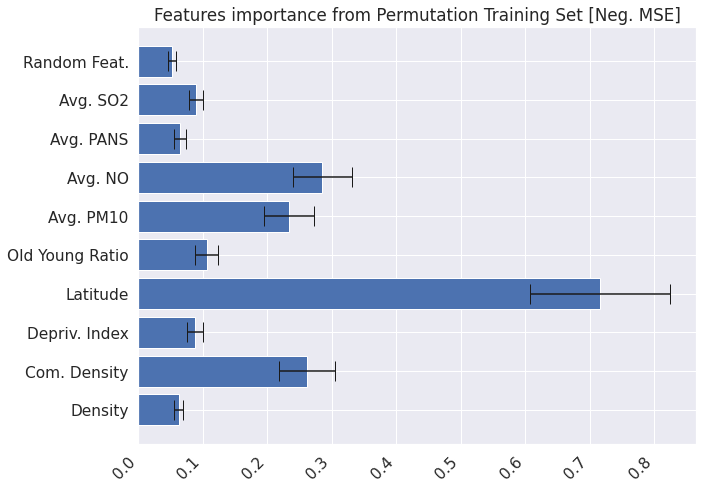

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.02716 +/- 0.00291
Feature:                   Com. Density, Score: 0.11393 +/- 0.01910
Feature:                  Depriv. Index, Score: 0.03841 +/- 0.00531
Feature:                       Latitude, Score: 0.31158 +/- 0.04724
Feature:                Old Young Ratio, Score: 0.04604 +/- 0.00805
Feature:                      Avg. PM10, Score: 0.10175 +/- 0.01713
Feature:                        Avg. NO, Score: 0.12430 +/- 0.01964
Feature:                      Avg. PANS, Score: 0.02821 +/- 0.00403
Feature:                       Avg. SO2, Score: 0.03888 +/- 0.00500


<Figure size 432x288 with 0 Axes>

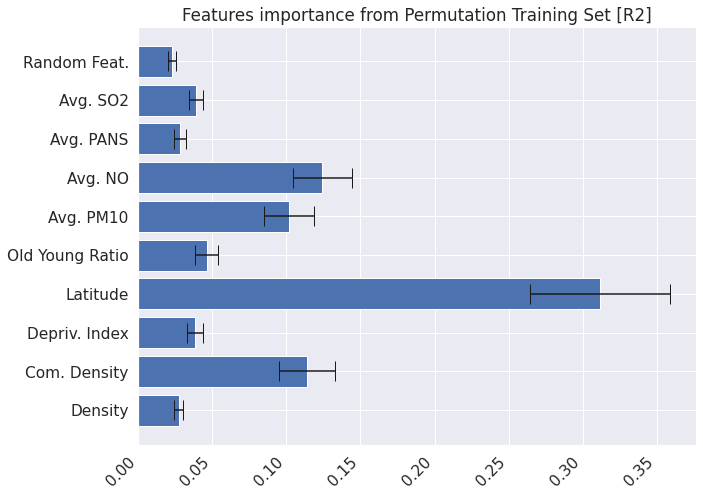

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38140  0.02522 
    Test set average RMSE:  1.01530  0.09878 

Prediction STD :    1.28715
True value STD :    1.47826
Difference in percentage:   12.92788

             Fullset RMSE:    0.36276
                       R2:    0.93978


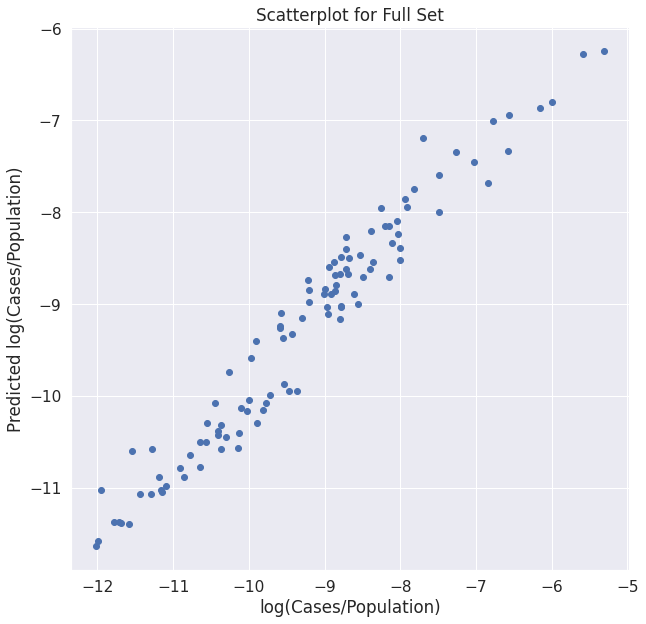

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05444 +/- 0.00518
Feature:                   Com. Density, Score: 1.68799 +/- 0.24912
Feature:                  Depriv. Index, Score: 0.07107 +/- 0.00673
Feature:                Old Young Ratio, Score: 0.21367 +/- 0.02347
Feature:                      Avg. PM10, Score: 0.26949 +/- 0.03407
Feature:                        Avg. NO, Score: 0.33675 +/- 0.03530
Feature:                      Avg. PANS, Score: 0.07941 +/- 0.01110
Feature:                       Avg. SO2, Score: 0.10387 +/- 0.01466


<Figure size 432x288 with 0 Axes>

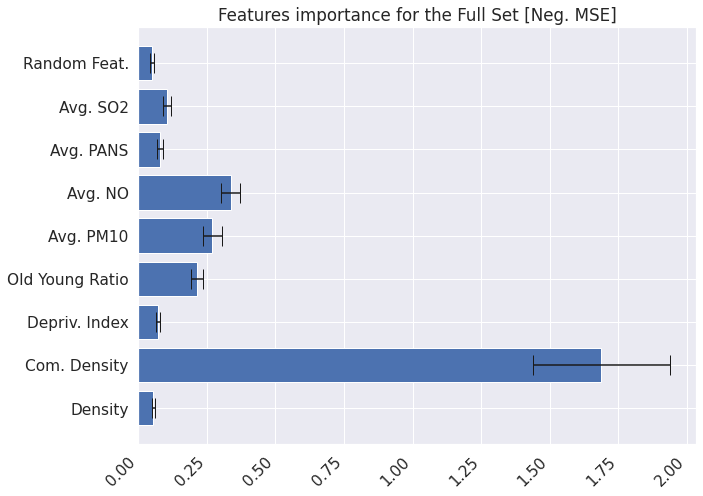

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02491 +/- 0.00237
Feature:                   Com. Density, Score: 0.77245 +/- 0.11400
Feature:                  Depriv. Index, Score: 0.03252 +/- 0.00308
Feature:                Old Young Ratio, Score: 0.09778 +/- 0.01074
Feature:                      Avg. PM10, Score: 0.12332 +/- 0.01559
Feature:                        Avg. NO, Score: 0.15410 +/- 0.01615
Feature:                      Avg. PANS, Score: 0.03634 +/- 0.00508
Feature:                       Avg. SO2, Score: 0.04753 +/- 0.00671


<Figure size 432x288 with 0 Axes>

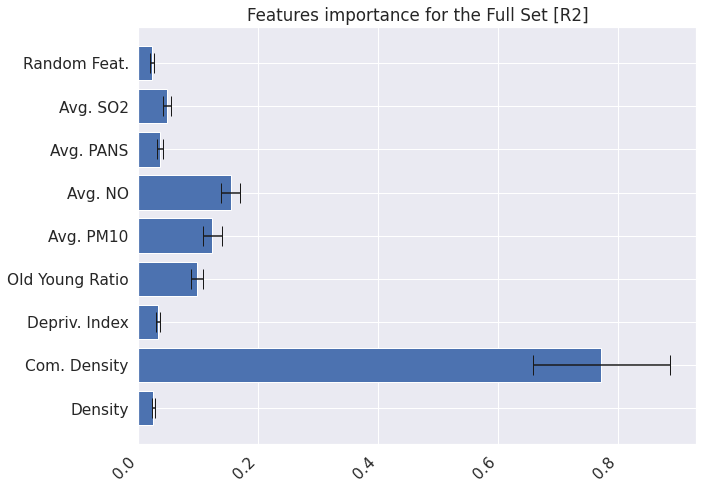

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37671
                       R2:    0.93819


<Figure size 432x288 with 0 Axes>

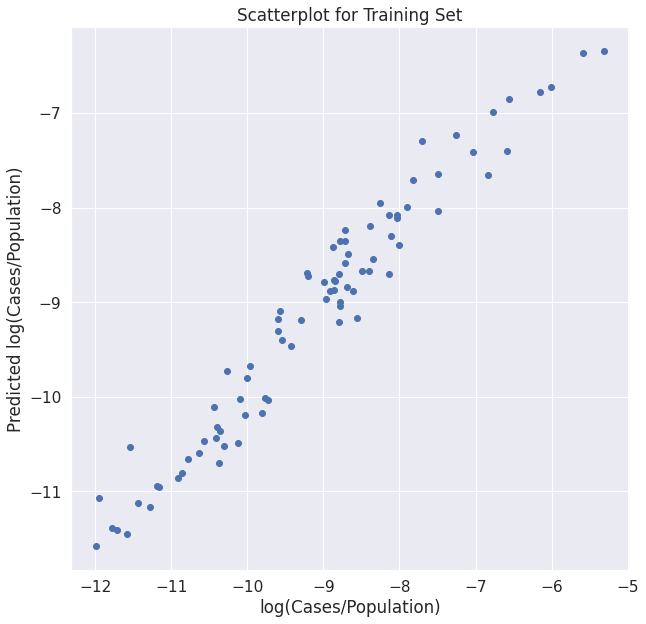

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.87108
                       R2:    0.45385


<Figure size 432x288 with 0 Axes>

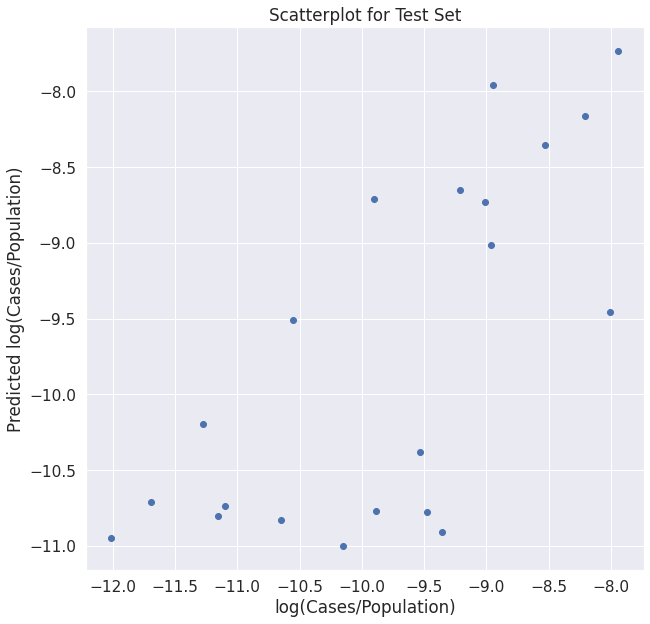

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.70303 +/- 0.29065
Feature:                Old Young Ratio, Score: 0.15757 +/- 0.10827
Feature:                      Avg. PANS, Score: 0.05415 +/- 0.04503
Feature:                       Avg. SO2, Score: 0.07030 +/- 0.02957


<Figure size 432x288 with 0 Axes>

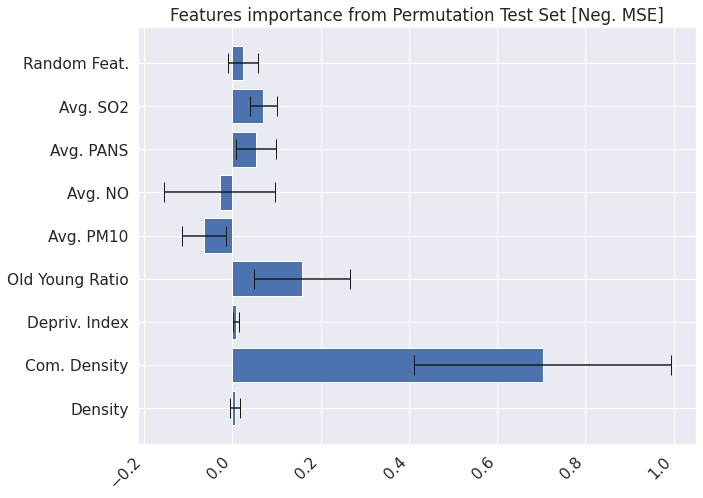

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.50602 +/- 0.20920
Feature:                Old Young Ratio, Score: 0.11341 +/- 0.07793
Feature:                      Avg. PANS, Score: 0.03898 +/- 0.03241
Feature:                       Avg. SO2, Score: 0.05060 +/- 0.02128


<Figure size 432x288 with 0 Axes>

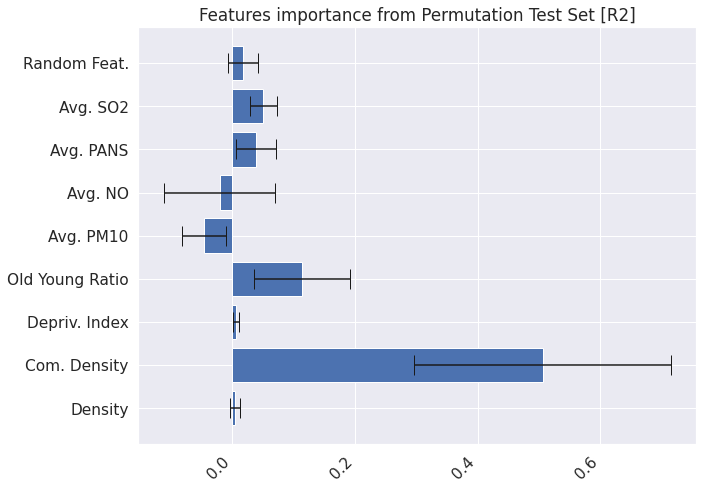

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 1.37802 +/- 0.22195
Feature:                Old Young Ratio, Score: 0.16049 +/- 0.03011
Feature:                      Avg. PM10, Score: 0.27545 +/- 0.04814
Feature:                        Avg. NO, Score: 0.51803 +/- 0.08209
Feature:                      Avg. PANS, Score: 0.09073 +/- 0.01392
Feature:                       Avg. SO2, Score: 0.10153 +/- 0.01430


<Figure size 432x288 with 0 Axes>

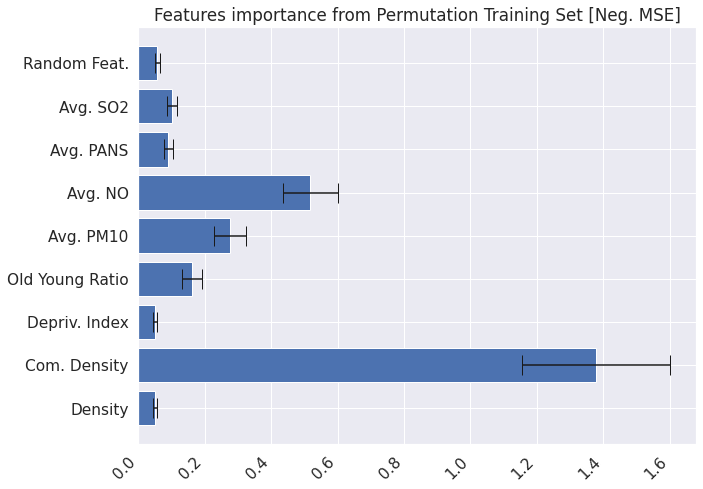

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.60018 +/- 0.09667
Feature:                Old Young Ratio, Score: 0.06990 +/- 0.01311
Feature:                      Avg. PM10, Score: 0.11997 +/- 0.02097
Feature:                        Avg. NO, Score: 0.22562 +/- 0.03575
Feature:                      Avg. PANS, Score: 0.03952 +/- 0.00606
Feature:                       Avg. SO2, Score: 0.04422 +/- 0.00623


<Figure size 432x288 with 0 Axes>

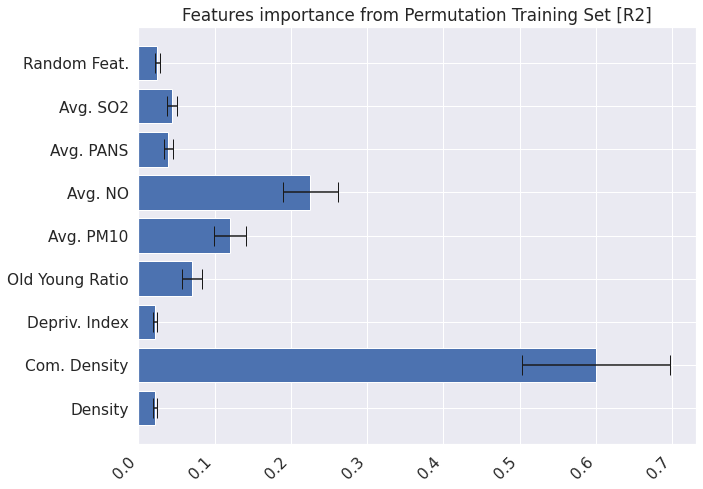

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39842  0.02434 
    Test set average RMSE:  1.03982  0.10301 

Prediction STD :    1.22442
True value STD :    1.47826
Difference in percentage:   17.17129

             Fullset RMSE:    0.37570
                       R2:    0.93541


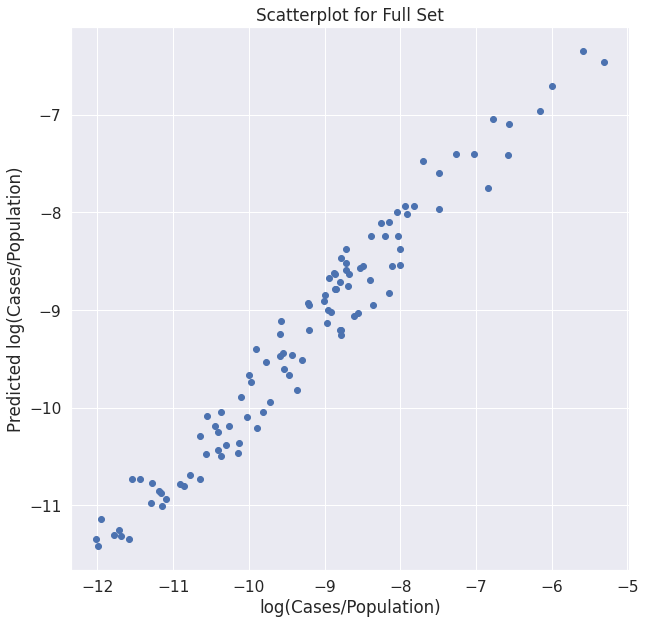

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.13282 +/- 0.01605
Feature:                  Depriv. Index, Score: 0.52213 +/- 0.06978
Feature:                Old Young Ratio, Score: 0.17480 +/- 0.01650
Feature:                      Avg. PM10, Score: 0.49776 +/- 0.06816
Feature:                        Avg. NO, Score: 0.55810 +/- 0.06973
Feature:                      Avg. PANS, Score: 0.13542 +/- 0.01486
Feature:                       Avg. SO2, Score: 0.18373 +/- 0.02565


<Figure size 432x288 with 0 Axes>

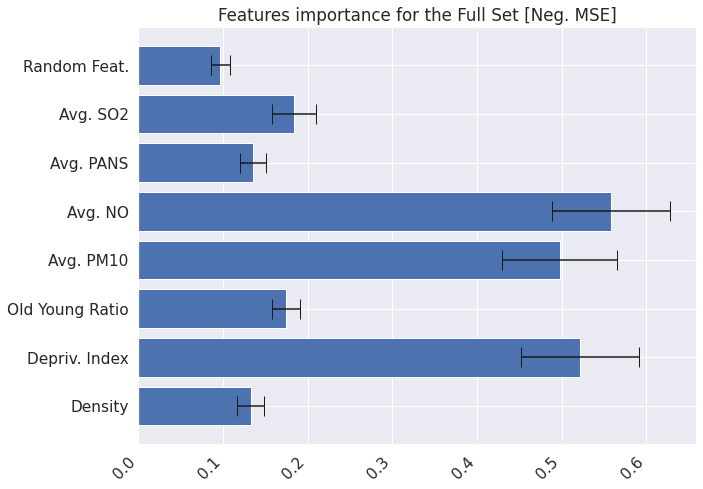

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06078 +/- 0.00735
Feature:                  Depriv. Index, Score: 0.23893 +/- 0.03193
Feature:                Old Young Ratio, Score: 0.07999 +/- 0.00755
Feature:                      Avg. PM10, Score: 0.22778 +/- 0.03119
Feature:                        Avg. NO, Score: 0.25539 +/- 0.03191
Feature:                      Avg. PANS, Score: 0.06197 +/- 0.00680
Feature:                       Avg. SO2, Score: 0.08408 +/- 0.01174


<Figure size 432x288 with 0 Axes>

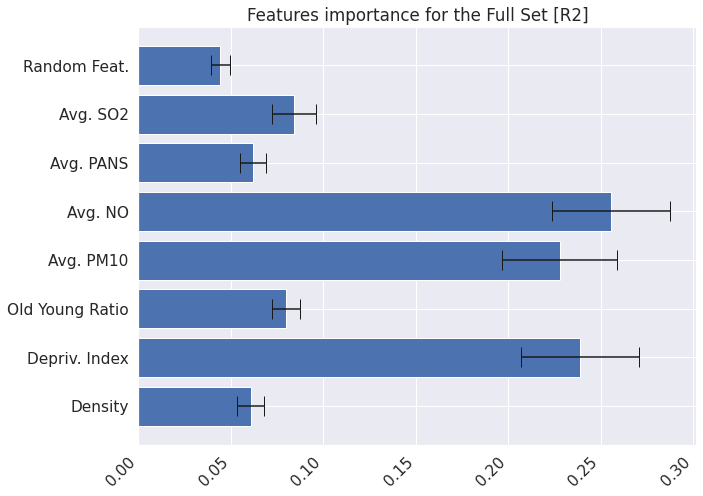

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.40003
                       R2:    0.93030


<Figure size 432x288 with 0 Axes>

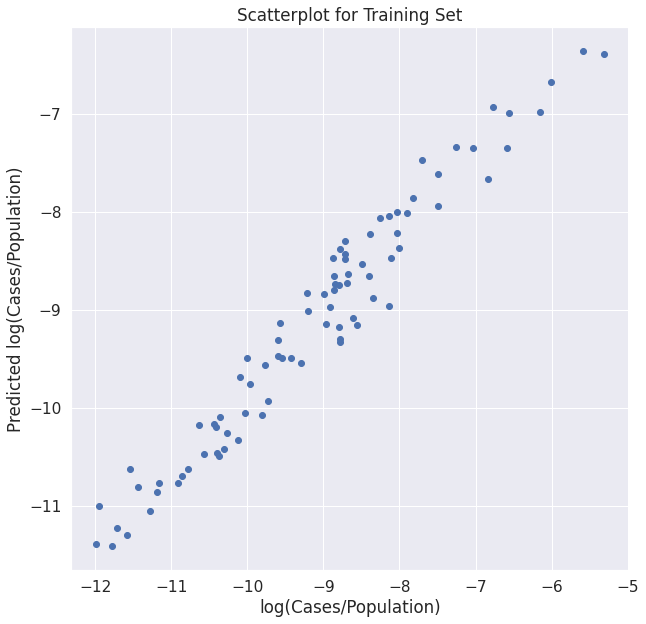

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.89369
                       R2:    0.42513


<Figure size 432x288 with 0 Axes>

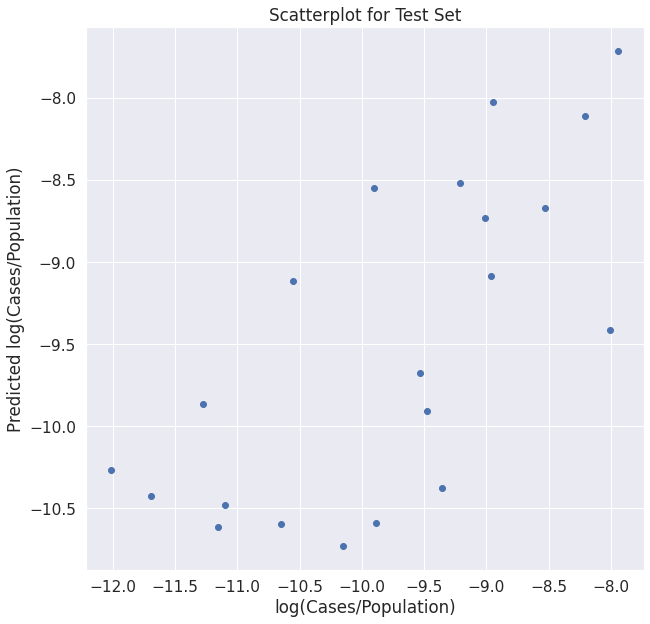

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05459 +/- 0.04728
Feature:                  Depriv. Index, Score: 0.33469 +/- 0.14075
Feature:                Old Young Ratio, Score: 0.06141 +/- 0.04877
Feature:                      Avg. PM10, Score: 0.14168 +/- 0.15395
Feature:                        Avg. NO, Score: 0.23328 +/- 0.15934
Feature:                      Avg. PANS, Score: 0.05094 +/- 0.03870
Feature:                       Avg. SO2, Score: 0.02637 +/- 0.03263


<Figure size 432x288 with 0 Axes>

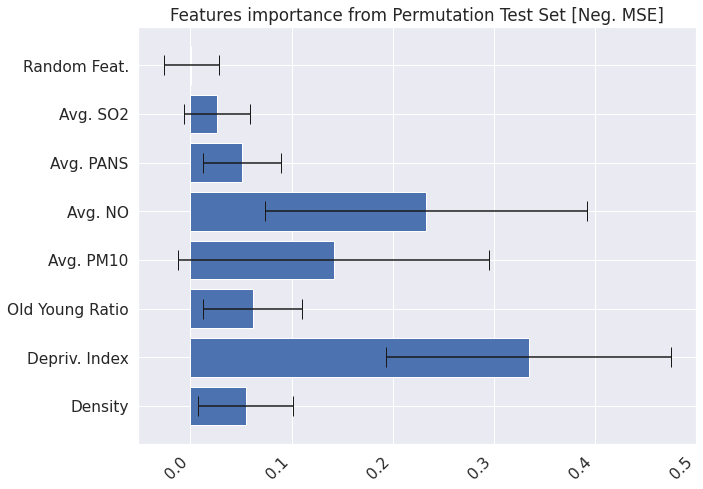

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.03929 +/- 0.03403
Feature:                  Depriv. Index, Score: 0.24090 +/- 0.10131
Feature:                Old Young Ratio, Score: 0.04420 +/- 0.03510
Feature:                      Avg. PM10, Score: 0.10197 +/- 0.11081
Feature:                        Avg. NO, Score: 0.16791 +/- 0.11468
Feature:                      Avg. PANS, Score: 0.03666 +/- 0.02786
Feature:                       Avg. SO2, Score: 0.01898 +/- 0.02349


<Figure size 432x288 with 0 Axes>

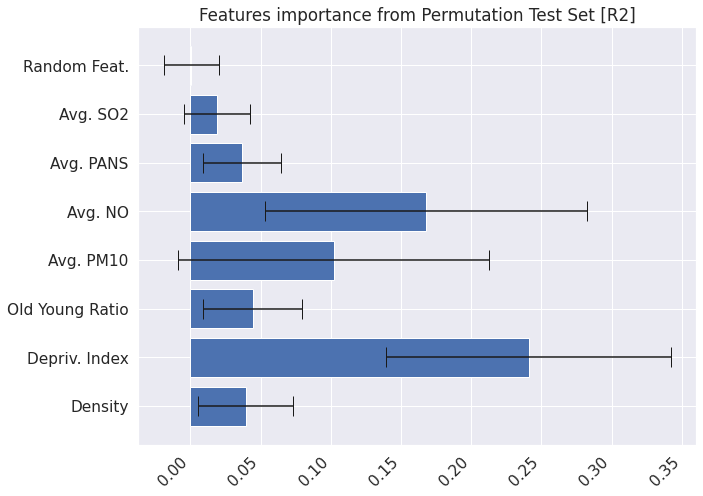

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12531 +/- 0.01312
Feature:                  Depriv. Index, Score: 0.42911 +/- 0.07225
Feature:                Old Young Ratio, Score: 0.15548 +/- 0.01977
Feature:                      Avg. PM10, Score: 0.65332 +/- 0.11227
Feature:                        Avg. NO, Score: 0.53073 +/- 0.08224
Feature:                      Avg. PANS, Score: 0.12995 +/- 0.01777
Feature:                       Avg. SO2, Score: 0.19480 +/- 0.02290


<Figure size 432x288 with 0 Axes>

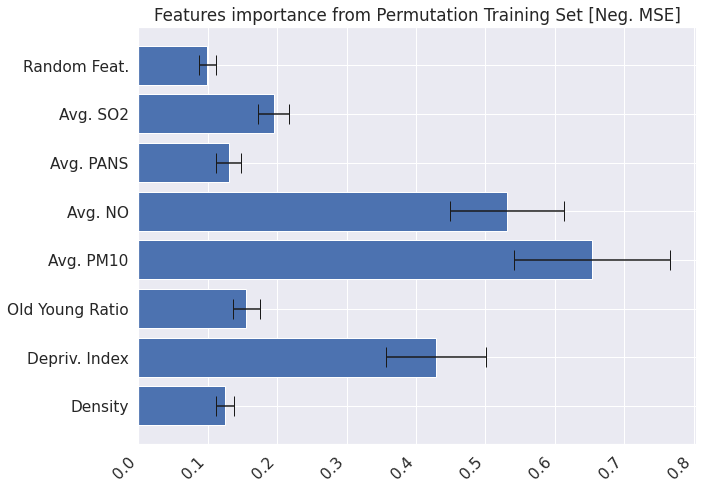

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05458 +/- 0.00571
Feature:                  Depriv. Index, Score: 0.18690 +/- 0.03147
Feature:                Old Young Ratio, Score: 0.06772 +/- 0.00861
Feature:                      Avg. PM10, Score: 0.28455 +/- 0.04890
Feature:                        Avg. NO, Score: 0.23115 +/- 0.03582
Feature:                      Avg. PANS, Score: 0.05660 +/- 0.00774
Feature:                       Avg. SO2, Score: 0.08484 +/- 0.00997


<Figure size 432x288 with 0 Axes>

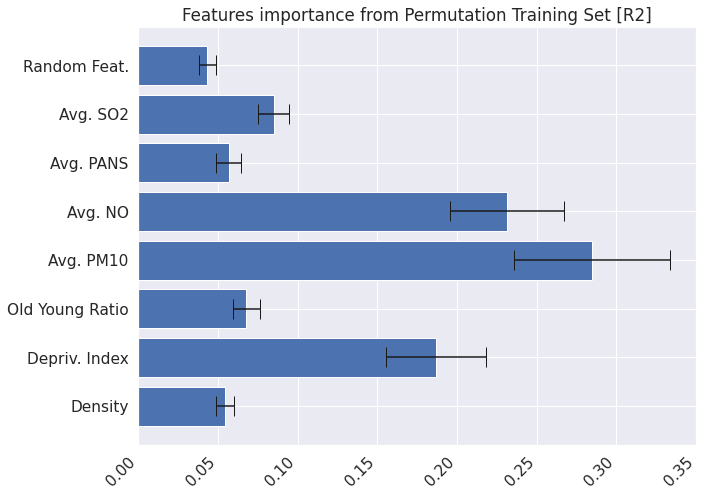

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35235  0.02132 
    Test set average RMSE:  0.94204  0.09424 

Prediction STD :    1.31955
True value STD :    1.47826
Difference in percentage:   10.73618

             Fullset RMSE:    0.35074
                       R2:    0.94371


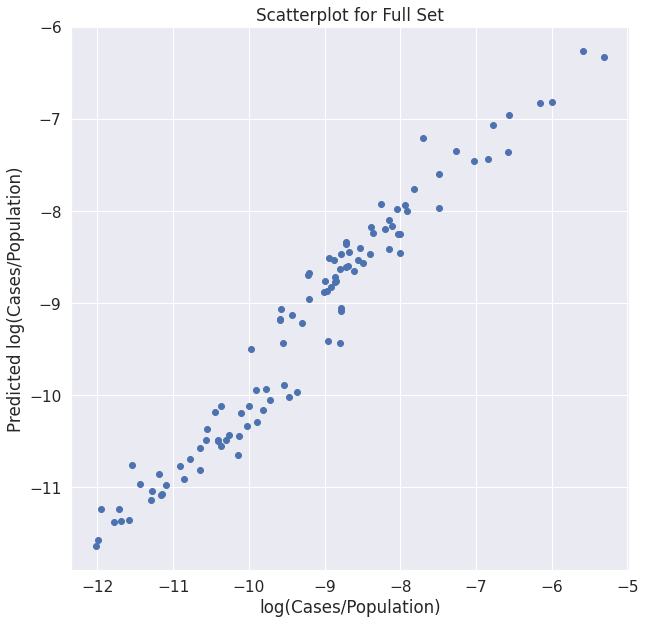

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 2.73102 +/- 0.36612
Feature:                Old Young Ratio, Score: 0.11408 +/- 0.01599
Feature:                      Avg. PM10, Score: 0.18314 +/- 0.01910
Feature:                        Avg. NO, Score: 0.19003 +/- 0.01887
Feature:                      Avg. PANS, Score: 0.05176 +/- 0.00571
Feature:                       Avg. SO2, Score: 0.06868 +/- 0.01074


<Figure size 432x288 with 0 Axes>

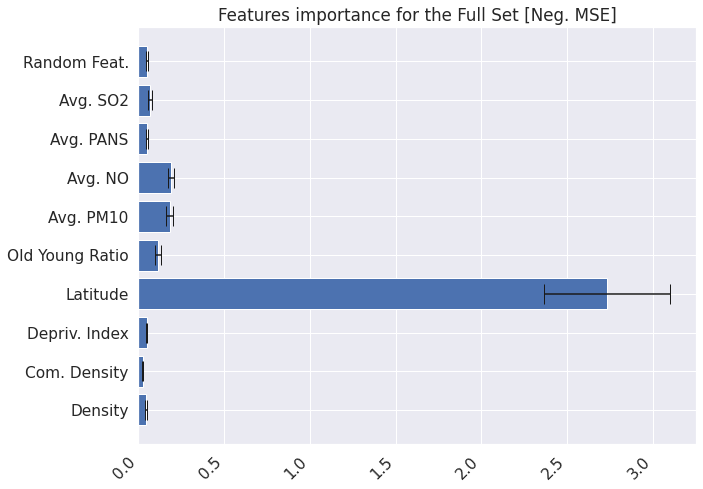

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                       Latitude, Score: 1.24975 +/- 0.16754
Feature:                Old Young Ratio, Score: 0.05220 +/- 0.00732
Feature:                      Avg. PM10, Score: 0.08381 +/- 0.00874
Feature:                        Avg. NO, Score: 0.08696 +/- 0.00864
Feature:                      Avg. PANS, Score: 0.02369 +/- 0.00261
Feature:                       Avg. SO2, Score: 0.03143 +/- 0.00491


<Figure size 432x288 with 0 Axes>

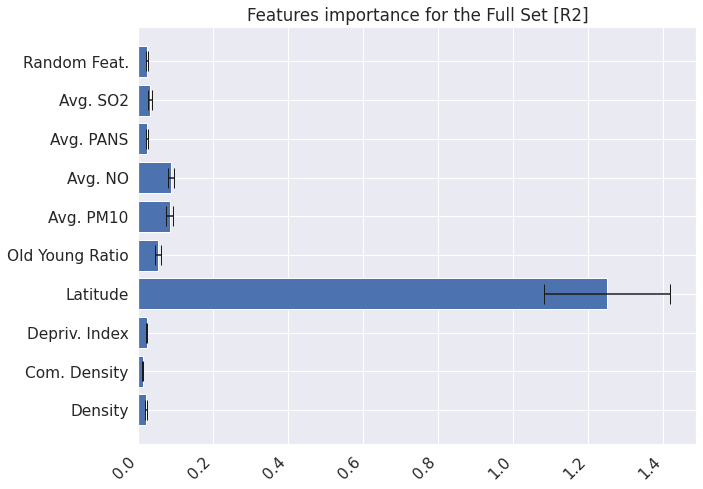

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.34790
                       R2:    0.94729


<Figure size 432x288 with 0 Axes>

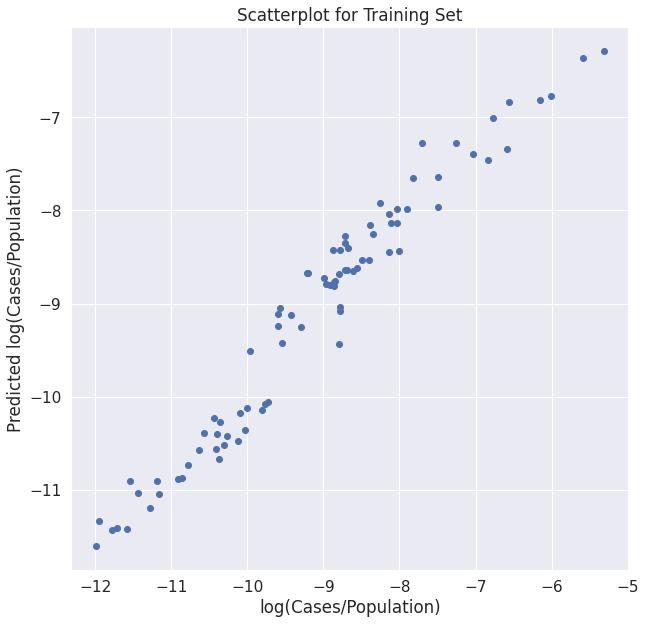

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.83241
                       R2:    0.50127


<Figure size 432x288 with 0 Axes>

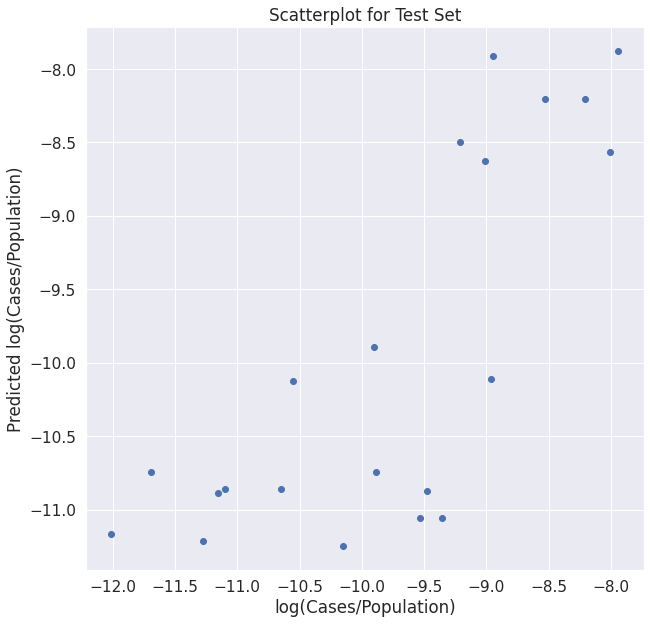

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 1.64833 +/- 0.51563
Feature:                       Avg. SO2, Score: 0.02694 +/- 0.01766


<Figure size 432x288 with 0 Axes>

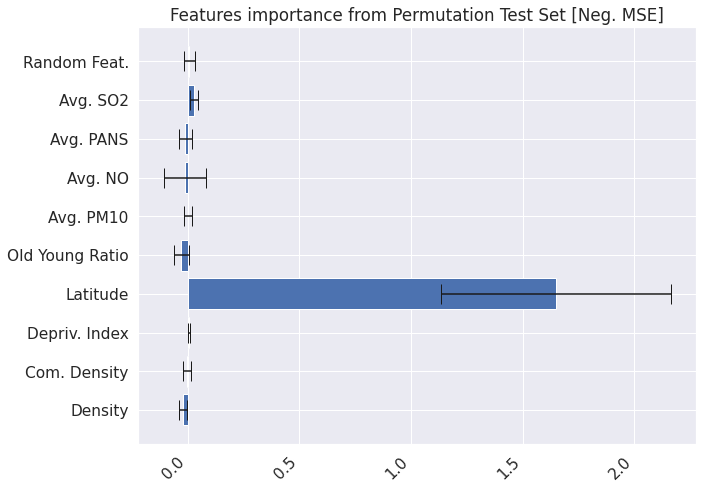

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                       Latitude, Score: 1.18642 +/- 0.37113
Feature:                       Avg. SO2, Score: 0.01939 +/- 0.01271


<Figure size 432x288 with 0 Axes>

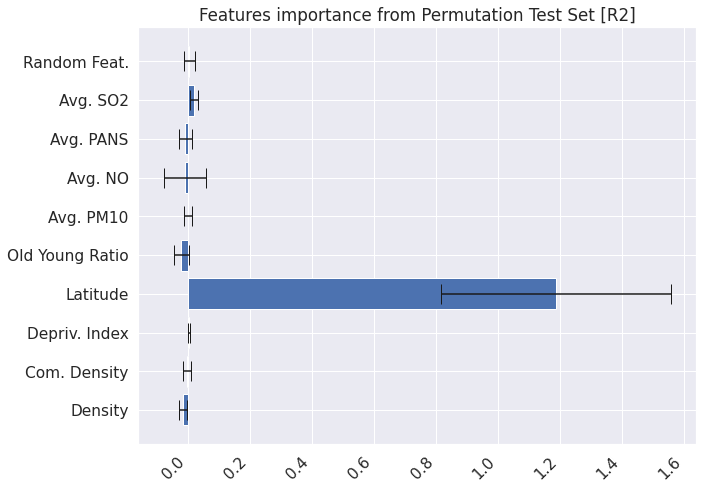

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 2.49741 +/- 0.41139
Feature:                Old Young Ratio, Score: 0.12751 +/- 0.02561
Feature:                      Avg. PM10, Score: 0.14831 +/- 0.02489
Feature:                        Avg. NO, Score: 0.26305 +/- 0.04160
Feature:                      Avg. PANS, Score: 0.06545 +/- 0.00904
Feature:                       Avg. SO2, Score: 0.07737 +/- 0.01085


<Figure size 432x288 with 0 Axes>

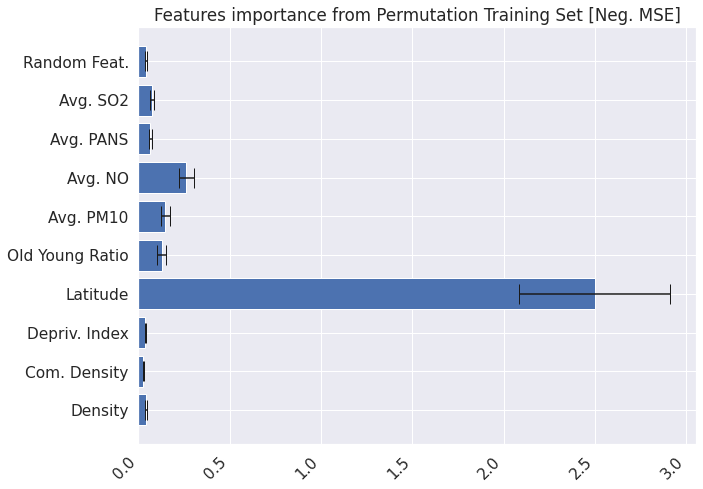

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                       Latitude, Score: 1.08773 +/- 0.17918
Feature:                Old Young Ratio, Score: 0.05554 +/- 0.01115
Feature:                      Avg. PM10, Score: 0.06460 +/- 0.01084
Feature:                        Avg. NO, Score: 0.11457 +/- 0.01812
Feature:                      Avg. PANS, Score: 0.02851 +/- 0.00394
Feature:                       Avg. SO2, Score: 0.03370 +/- 0.00472


<Figure size 432x288 with 0 Axes>

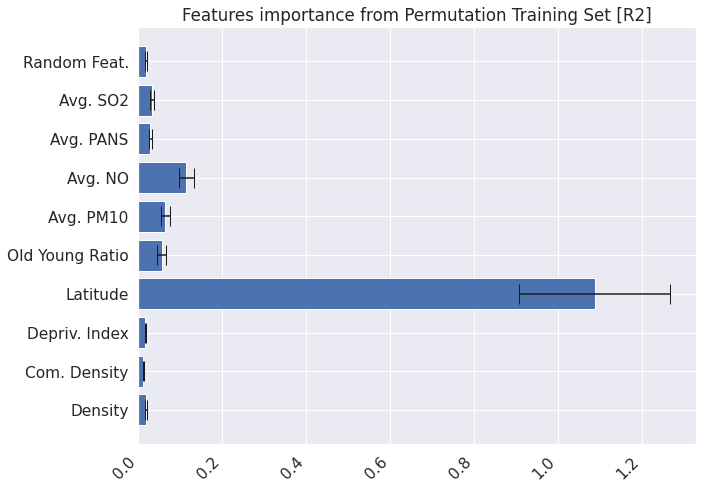

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37682  0.01636 
    Test set average RMSE:  0.99147  0.08482 

Prediction STD :    1.26336
True value STD :    1.47826
Difference in percentage:   14.53761

             Fullset RMSE:    0.36289
                       R2:    0.93974


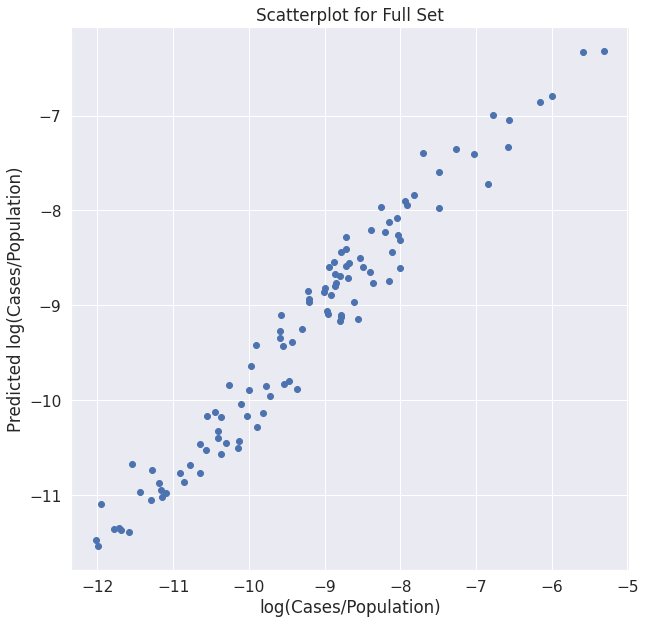

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08019 +/- 0.00911
Feature:                   Com. Density, Score: 0.68759 +/- 0.09600
Feature:                  Depriv. Index, Score: 0.24921 +/- 0.03345
Feature:                Old Young Ratio, Score: 0.14052 +/- 0.01457
Feature:                      Avg. PM10, Score: 0.29622 +/- 0.03470
Feature:                        Avg. NO, Score: 0.37565 +/- 0.04482
Feature:                      Avg. PANS, Score: 0.09138 +/- 0.01087
Feature:                       Avg. SO2, Score: 0.12384 +/- 0.01713


<Figure size 432x288 with 0 Axes>

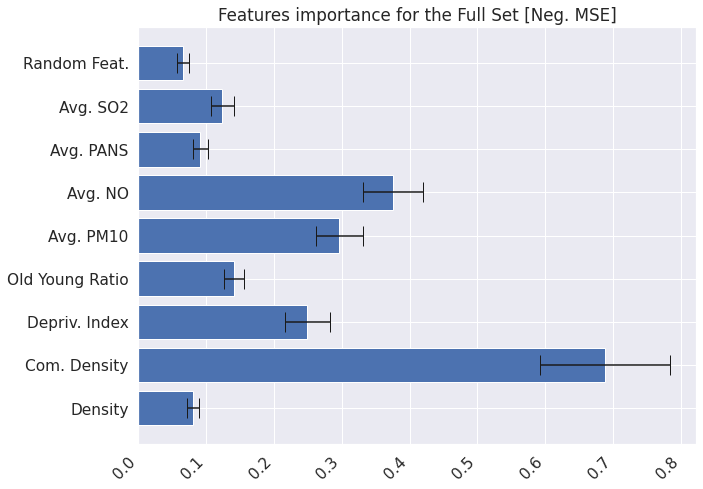

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03670 +/- 0.00417
Feature:                   Com. Density, Score: 0.31465 +/- 0.04393
Feature:                  Depriv. Index, Score: 0.11404 +/- 0.01531
Feature:                Old Young Ratio, Score: 0.06430 +/- 0.00667
Feature:                      Avg. PM10, Score: 0.13556 +/- 0.01588
Feature:                        Avg. NO, Score: 0.17190 +/- 0.02051
Feature:                      Avg. PANS, Score: 0.04182 +/- 0.00497
Feature:                       Avg. SO2, Score: 0.05667 +/- 0.00784


<Figure size 432x288 with 0 Axes>

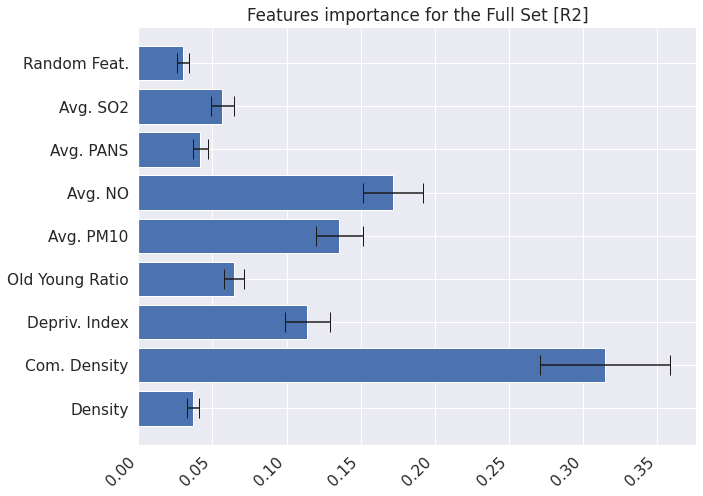

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37450
                       R2:    0.93892


<Figure size 432x288 with 0 Axes>

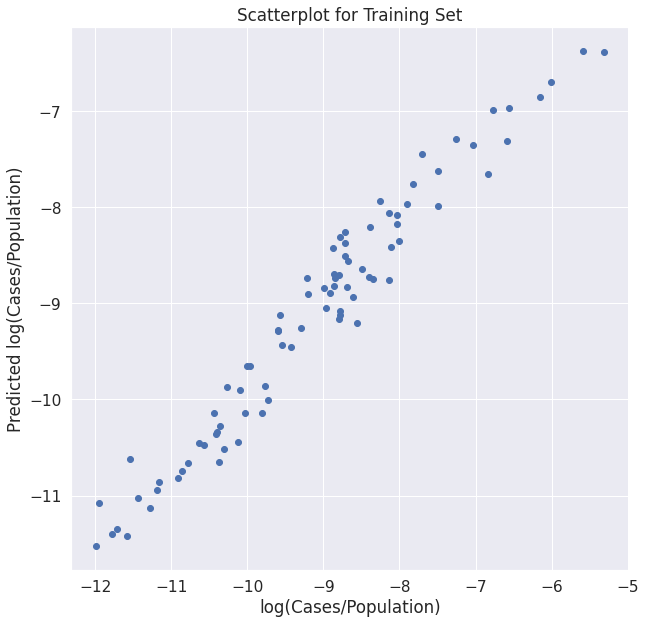

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.87729
                       R2:    0.44603


<Figure size 432x288 with 0 Axes>

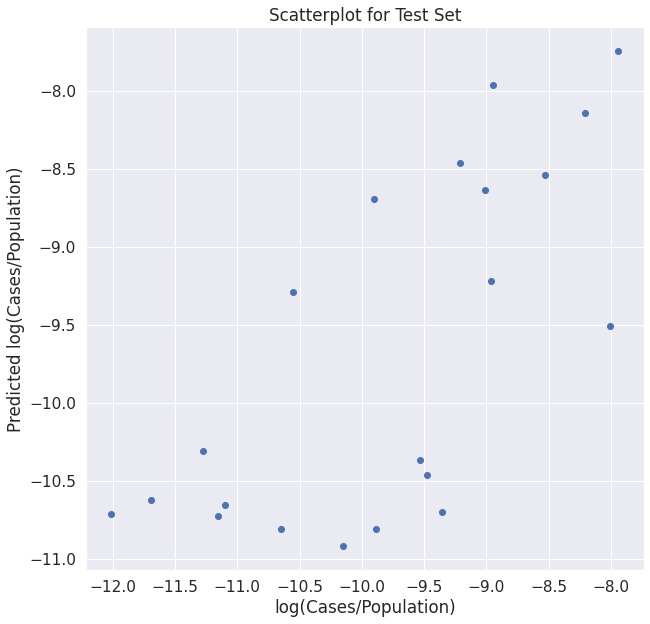

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.26437 +/- 0.18606
Feature:                  Depriv. Index, Score: 0.09283 +/- 0.06560
Feature:                Old Young Ratio, Score: 0.05879 +/- 0.04962
Feature:                      Avg. PANS, Score: 0.05393 +/- 0.04352
Feature:                       Avg. SO2, Score: 0.01563 +/- 0.02715


<Figure size 432x288 with 0 Axes>

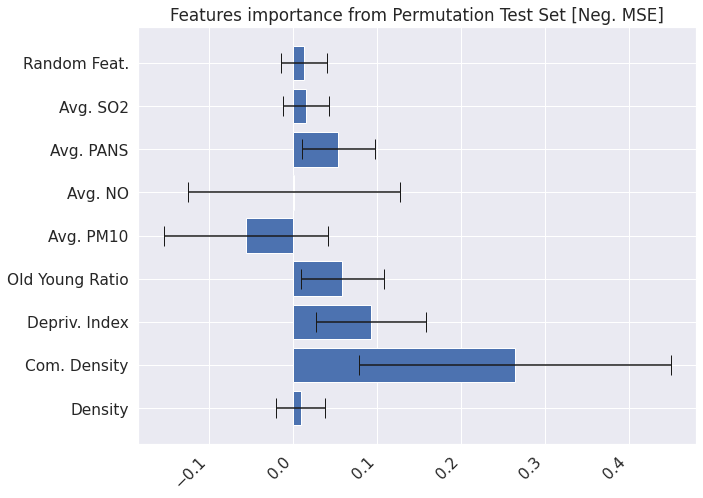

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.19029 +/- 0.13392
Feature:                  Depriv. Index, Score: 0.06682 +/- 0.04722
Feature:                Old Young Ratio, Score: 0.04231 +/- 0.03571
Feature:                      Avg. PANS, Score: 0.03881 +/- 0.03133
Feature:                       Avg. SO2, Score: 0.01125 +/- 0.01954


<Figure size 432x288 with 0 Axes>

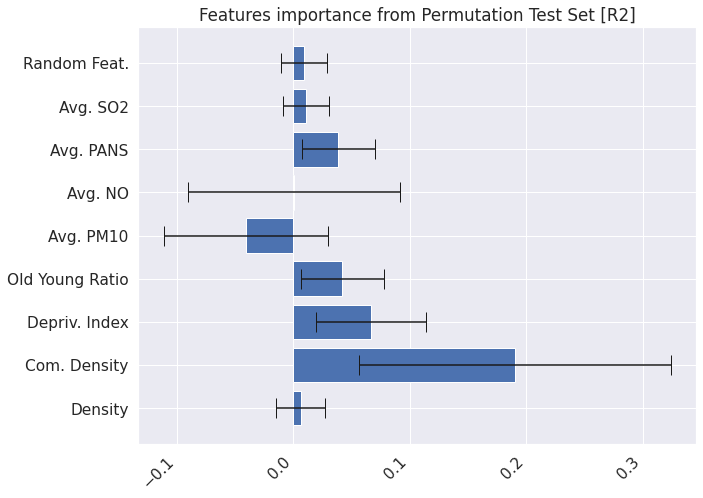

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07871 +/- 0.00909
Feature:                   Com. Density, Score: 0.64665 +/- 0.09785
Feature:                  Depriv. Index, Score: 0.17591 +/- 0.02948
Feature:                Old Young Ratio, Score: 0.12726 +/- 0.02127
Feature:                      Avg. PM10, Score: 0.39050 +/- 0.06586
Feature:                        Avg. NO, Score: 0.42193 +/- 0.06701
Feature:                      Avg. PANS, Score: 0.08908 +/- 0.01315
Feature:                       Avg. SO2, Score: 0.13344 +/- 0.01693


<Figure size 432x288 with 0 Axes>

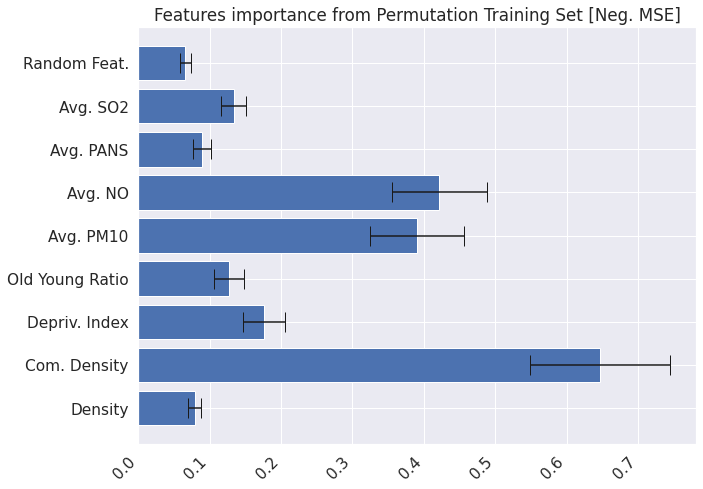

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.03428 +/- 0.00396
Feature:                   Com. Density, Score: 0.28165 +/- 0.04262
Feature:                  Depriv. Index, Score: 0.07662 +/- 0.01284
Feature:                Old Young Ratio, Score: 0.05543 +/- 0.00926
Feature:                      Avg. PM10, Score: 0.17008 +/- 0.02868
Feature:                        Avg. NO, Score: 0.18377 +/- 0.02919
Feature:                      Avg. PANS, Score: 0.03880 +/- 0.00573
Feature:                       Avg. SO2, Score: 0.05812 +/- 0.00737


<Figure size 432x288 with 0 Axes>

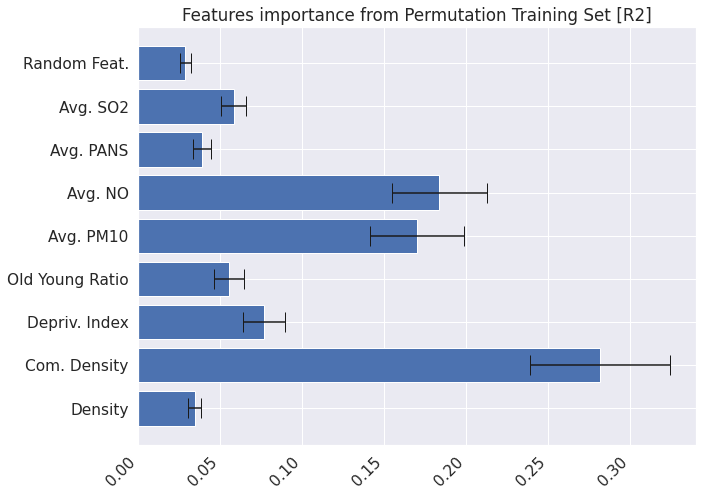

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39325  0.02035 
    Test set average RMSE:  1.06243  0.10774 

Prediction STD :    1.22421
True value STD :    1.47826
Difference in percentage:   17.18567

             Fullset RMSE:    0.37585
                       R2:    0.93536


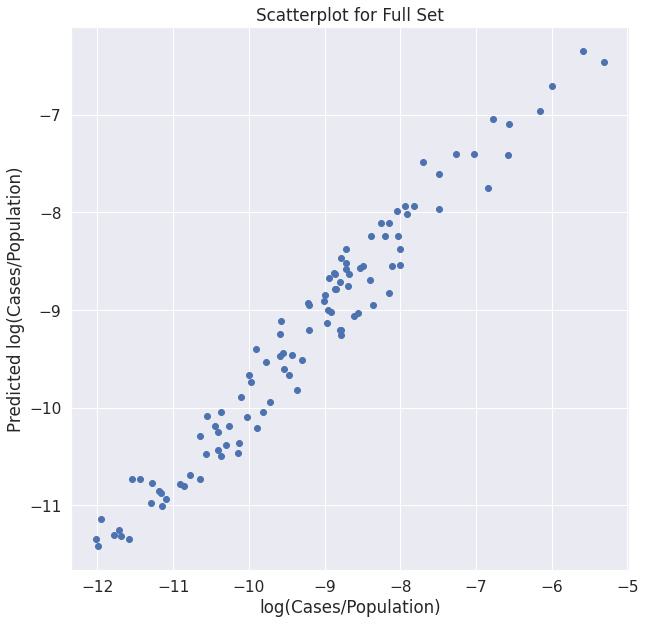

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.13280 +/- 0.01600
Feature:                  Depriv. Index, Score: 0.52152 +/- 0.06967
Feature:                Old Young Ratio, Score: 0.17517 +/- 0.01653
Feature:                      Avg. PM10, Score: 0.49825 +/- 0.06822
Feature:                        Avg. NO, Score: 0.55853 +/- 0.06986
Feature:                      Avg. PANS, Score: 0.13575 +/- 0.01486
Feature:                       Avg. SO2, Score: 0.18308 +/- 0.02556


<Figure size 432x288 with 0 Axes>

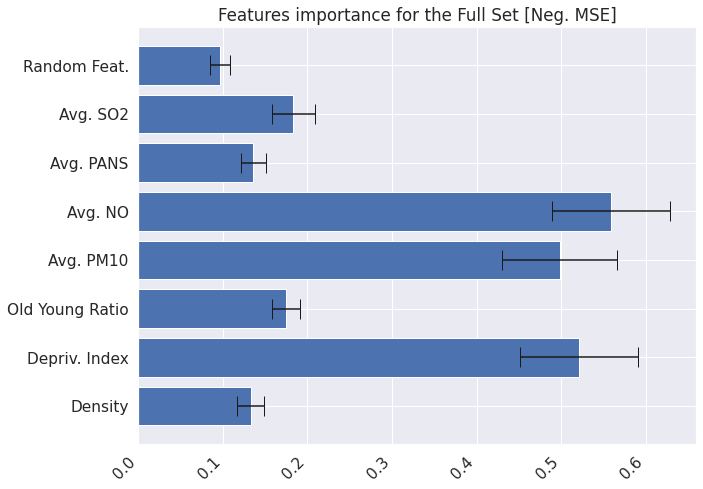

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06077 +/- 0.00732
Feature:                  Depriv. Index, Score: 0.23866 +/- 0.03188
Feature:                Old Young Ratio, Score: 0.08016 +/- 0.00756
Feature:                      Avg. PM10, Score: 0.22801 +/- 0.03122
Feature:                        Avg. NO, Score: 0.25559 +/- 0.03197
Feature:                      Avg. PANS, Score: 0.06212 +/- 0.00680
Feature:                       Avg. SO2, Score: 0.08378 +/- 0.01170


<Figure size 432x288 with 0 Axes>

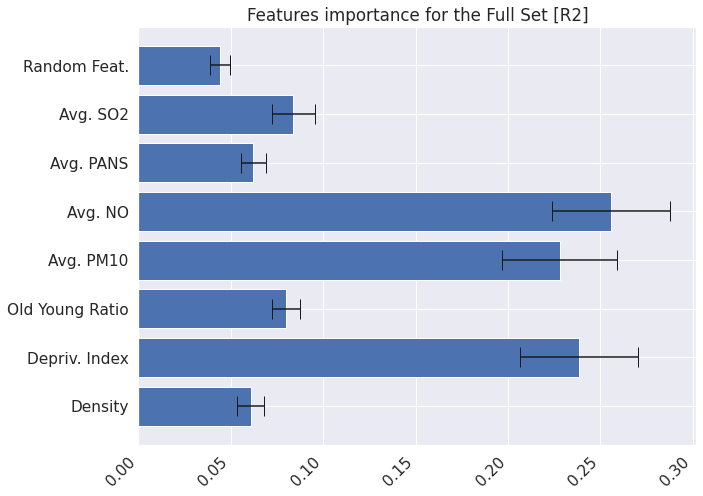

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.40014
                       R2:    0.93026


<Figure size 432x288 with 0 Axes>

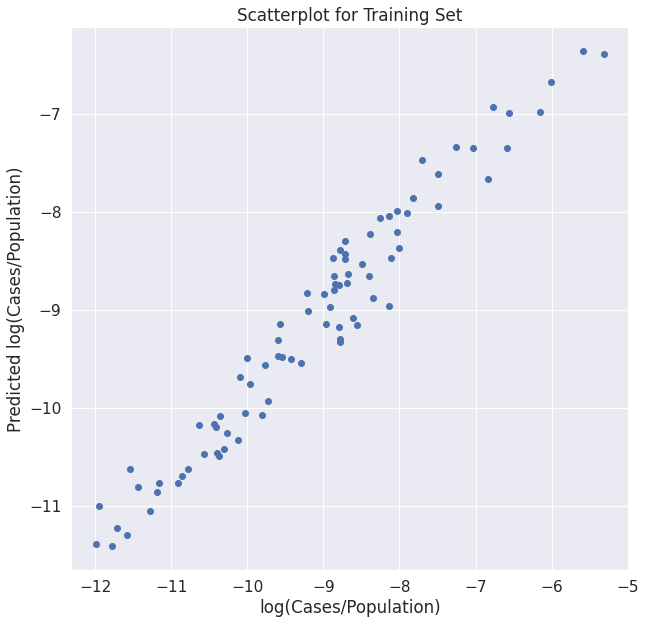

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.89422
                       R2:    0.42445


<Figure size 432x288 with 0 Axes>

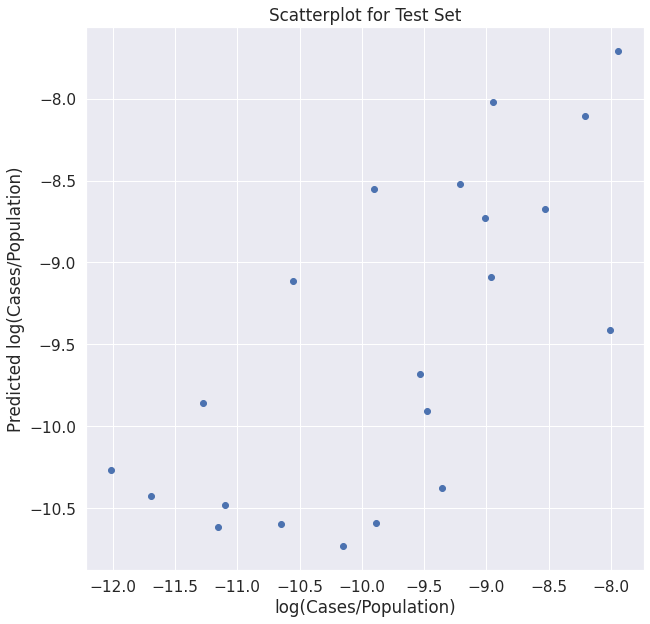

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05452 +/- 0.04730
Feature:                  Depriv. Index, Score: 0.33442 +/- 0.14080
Feature:                Old Young Ratio, Score: 0.06097 +/- 0.04897
Feature:                      Avg. PM10, Score: 0.14056 +/- 0.15387
Feature:                        Avg. NO, Score: 0.23355 +/- 0.15946
Feature:                      Avg. PANS, Score: 0.05079 +/- 0.03851
Feature:                       Avg. SO2, Score: 0.02588 +/- 0.03263


<Figure size 432x288 with 0 Axes>

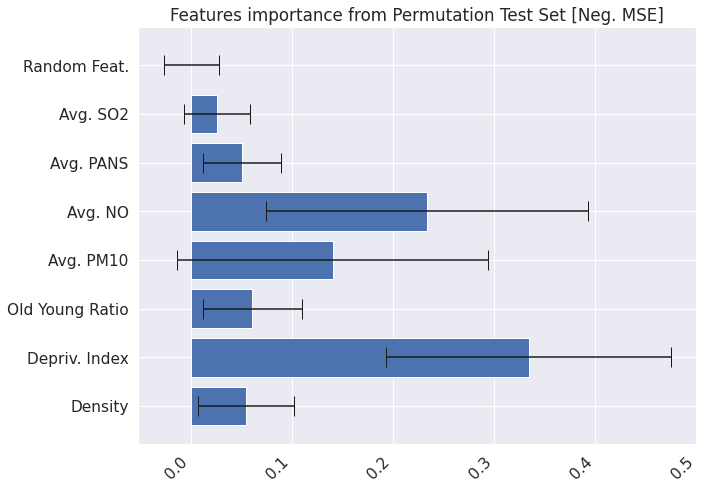

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.03925 +/- 0.03405
Feature:                  Depriv. Index, Score: 0.24071 +/- 0.10134
Feature:                Old Young Ratio, Score: 0.04388 +/- 0.03525
Feature:                      Avg. PM10, Score: 0.10117 +/- 0.11075
Feature:                        Avg. NO, Score: 0.16810 +/- 0.11477
Feature:                      Avg. PANS, Score: 0.03656 +/- 0.02772
Feature:                       Avg. SO2, Score: 0.01863 +/- 0.02349


<Figure size 432x288 with 0 Axes>

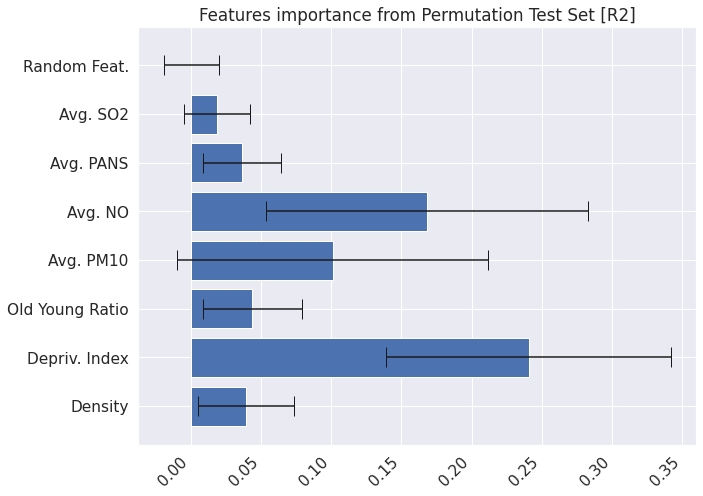

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12531 +/- 0.01315
Feature:                  Depriv. Index, Score: 0.42942 +/- 0.07229
Feature:                Old Young Ratio, Score: 0.15602 +/- 0.01978
Feature:                      Avg. PM10, Score: 0.65387 +/- 0.11238
Feature:                        Avg. NO, Score: 0.52961 +/- 0.08194
Feature:                      Avg. PANS, Score: 0.13001 +/- 0.01782
Feature:                       Avg. SO2, Score: 0.19448 +/- 0.02287


<Figure size 432x288 with 0 Axes>

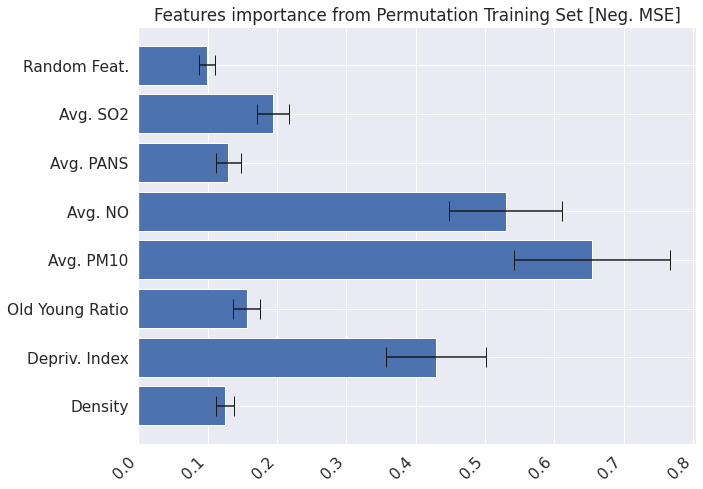

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05458 +/- 0.00573
Feature:                  Depriv. Index, Score: 0.18703 +/- 0.03149
Feature:                Old Young Ratio, Score: 0.06795 +/- 0.00862
Feature:                      Avg. PM10, Score: 0.28479 +/- 0.04894
Feature:                        Avg. NO, Score: 0.23067 +/- 0.03569
Feature:                      Avg. PANS, Score: 0.05663 +/- 0.00776
Feature:                       Avg. SO2, Score: 0.08470 +/- 0.00996


<Figure size 432x288 with 0 Axes>

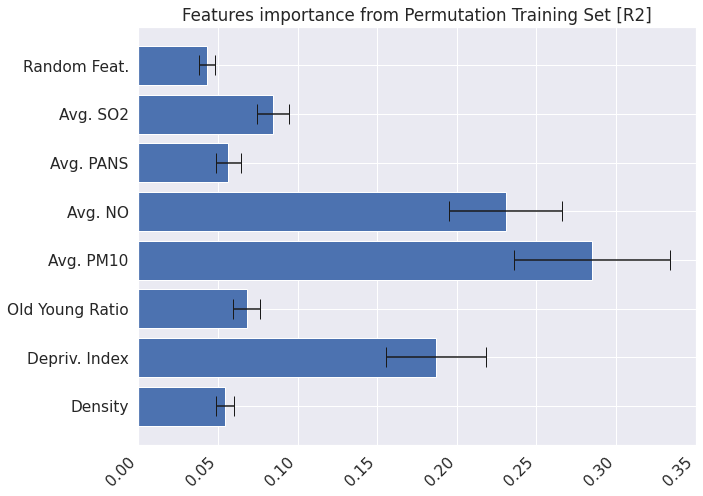

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.43199  0.03044 
    Test set average RMSE:  0.94512  0.09324 

Prediction STD :    1.28908
True value STD :    1.47826
Difference in percentage:   12.79762

             Fullset RMSE:    0.43901
                       R2:    0.91180


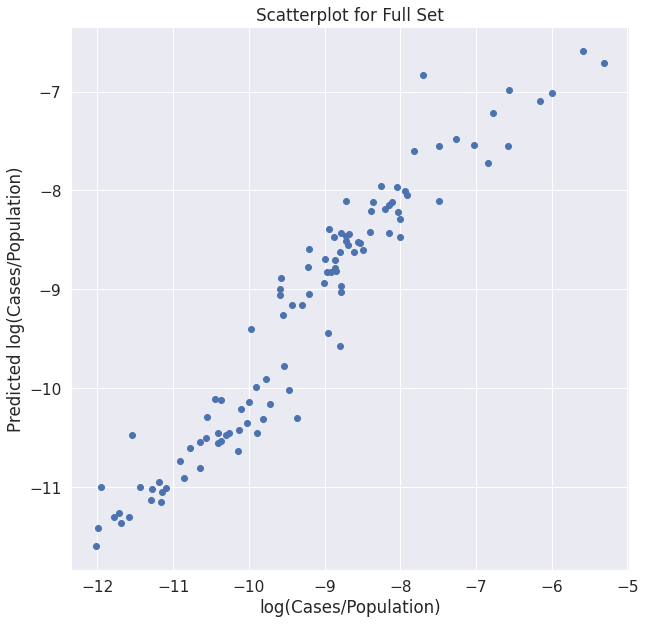

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 2.60956 +/- 0.34678
Feature:                Old Young Ratio, Score: 0.10099 +/- 0.01695
Feature:                      Avg. PM10, Score: 0.18648 +/- 0.02058
Feature:                        Avg. NO, Score: 0.17742 +/- 0.01986
Feature:                      Avg. PANS, Score: 0.05234 +/- 0.00678
Feature:                       Avg. SO2, Score: 0.05478 +/- 0.00839


<Figure size 432x288 with 0 Axes>

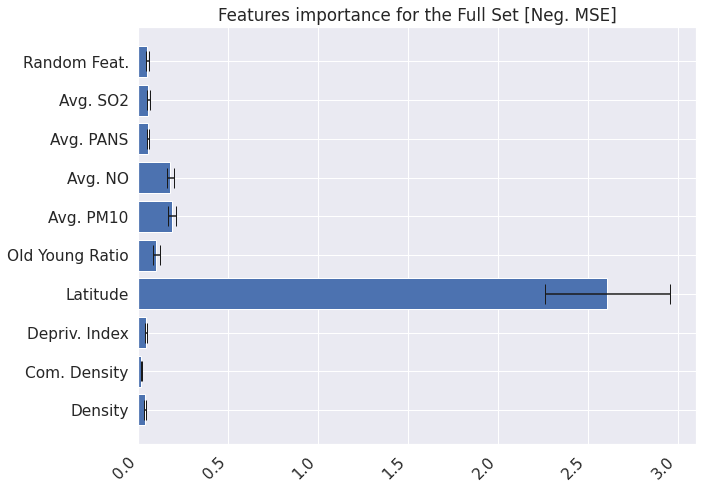

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                       Latitude, Score: 1.19417 +/- 0.15869
Feature:                Old Young Ratio, Score: 0.04621 +/- 0.00776
Feature:                      Avg. PM10, Score: 0.08534 +/- 0.00942
Feature:                        Avg. NO, Score: 0.08119 +/- 0.00909
Feature:                      Avg. PANS, Score: 0.02395 +/- 0.00310
Feature:                       Avg. SO2, Score: 0.02507 +/- 0.00384


<Figure size 432x288 with 0 Axes>

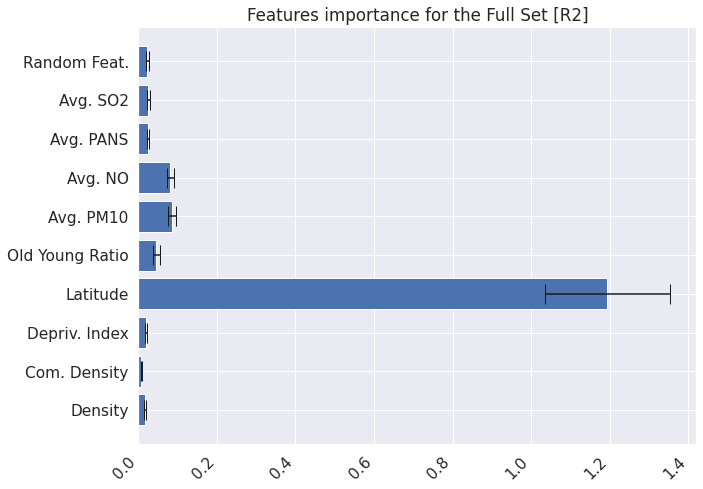

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.41134
                       R2:    0.92631


<Figure size 432x288 with 0 Axes>

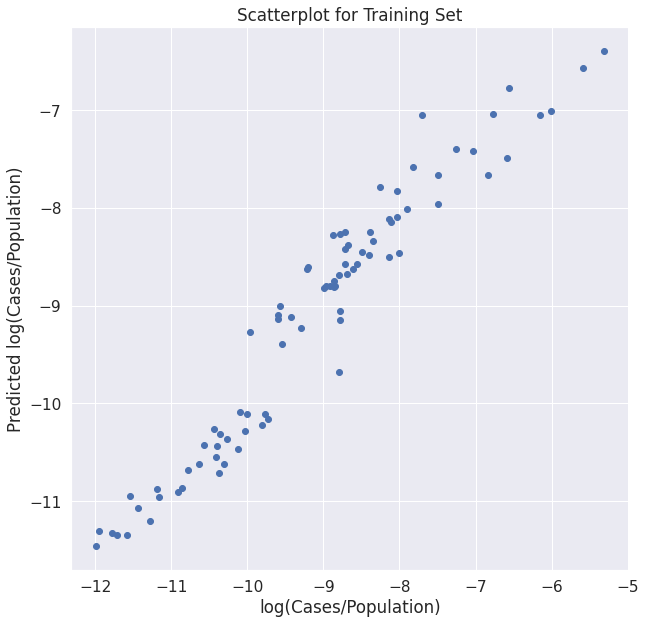

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.86684
                       R2:    0.45916


<Figure size 432x288 with 0 Axes>

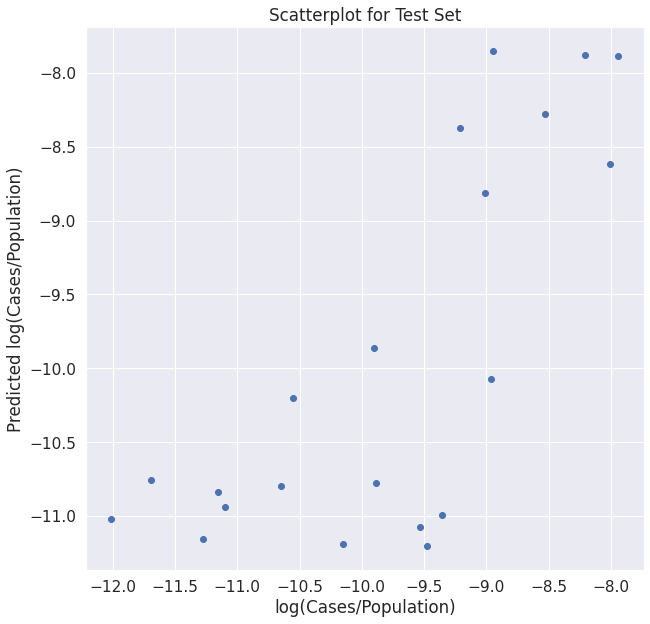

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.00709 +/- 0.01937
Feature:                       Latitude, Score: 1.45612 +/- 0.46983
Feature:                       Avg. SO2, Score: 0.01983 +/- 0.01959


<Figure size 432x288 with 0 Axes>

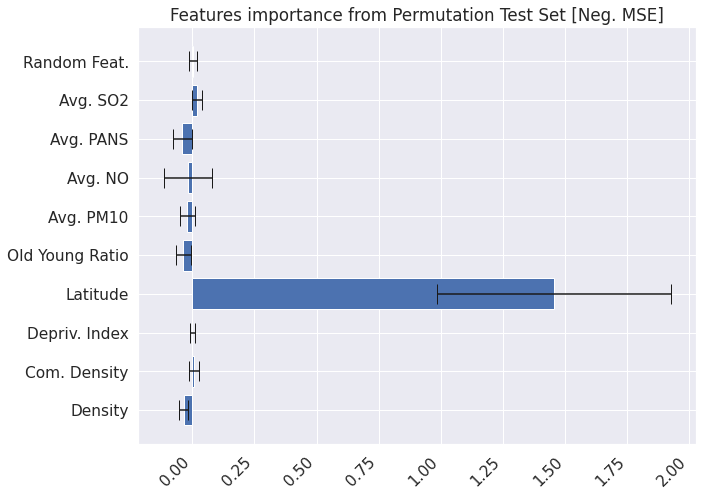

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.00510 +/- 0.01394
Feature:                       Latitude, Score: 1.04807 +/- 0.33817
Feature:                       Avg. SO2, Score: 0.01428 +/- 0.01410


<Figure size 432x288 with 0 Axes>

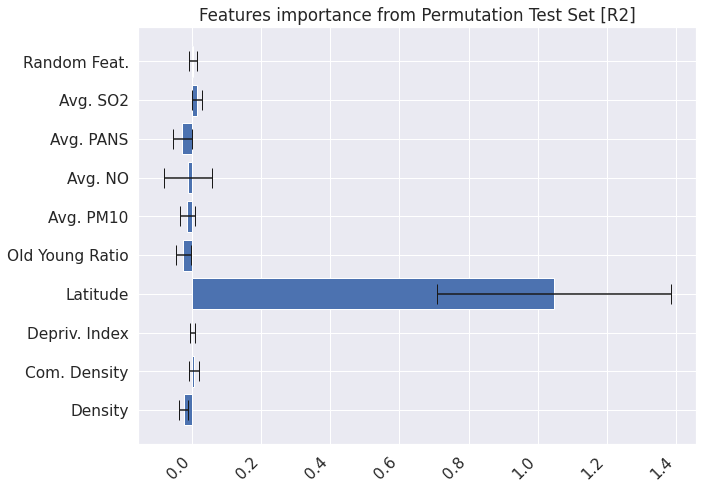

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.05833 +/- 0.00846
Feature:                       Latitude, Score: 2.29409 +/- 0.38095
Feature:                Old Young Ratio, Score: 0.10636 +/- 0.02212
Feature:                      Avg. PM10, Score: 0.18909 +/- 0.03773
Feature:                        Avg. NO, Score: 0.22451 +/- 0.03838
Feature:                      Avg. PANS, Score: 0.05894 +/- 0.01104
Feature:                       Avg. SO2, Score: 0.07552 +/- 0.01201


<Figure size 432x288 with 0 Axes>

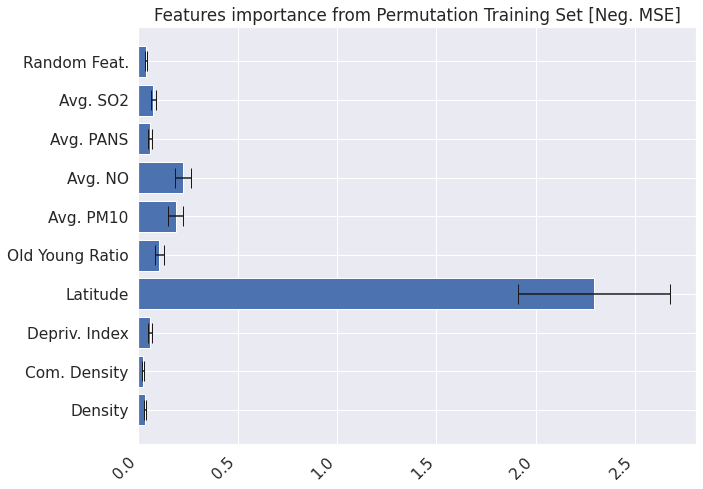

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.02541 +/- 0.00369
Feature:                       Latitude, Score: 0.99917 +/- 0.16592
Feature:                Old Young Ratio, Score: 0.04632 +/- 0.00964
Feature:                      Avg. PM10, Score: 0.08236 +/- 0.01643
Feature:                        Avg. NO, Score: 0.09778 +/- 0.01672
Feature:                      Avg. PANS, Score: 0.02567 +/- 0.00481
Feature:                       Avg. SO2, Score: 0.03289 +/- 0.00523


<Figure size 432x288 with 0 Axes>

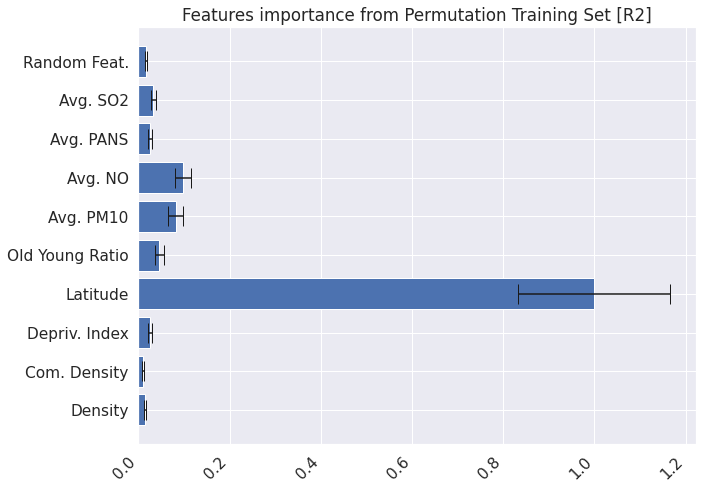

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.54922  0.03532 
    Test set average RMSE:  1.01118  0.10864 

Prediction STD :    1.16516
True value STD :    1.47826
Difference in percentage:   21.18024

             Fullset RMSE:    0.58136
                       R2:    0.84534


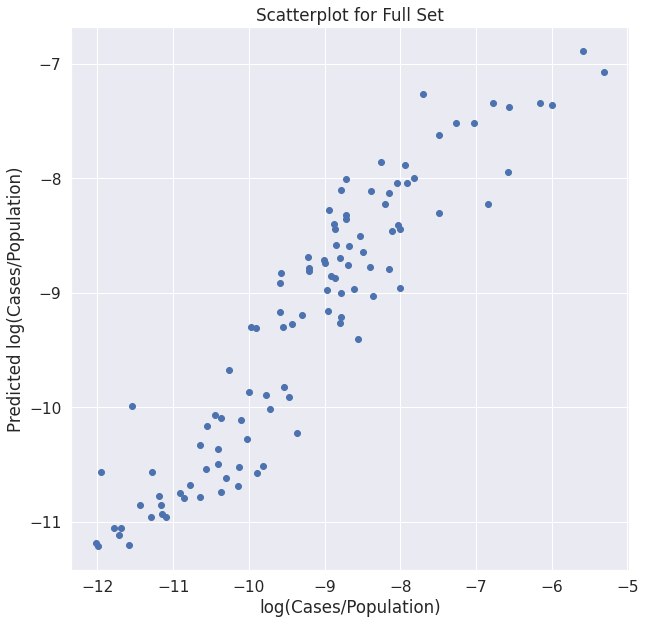

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06538 +/- 0.00977
Feature:                   Com. Density, Score: 0.68877 +/- 0.10705
Feature:                  Depriv. Index, Score: 0.21871 +/- 0.03927
Feature:                Old Young Ratio, Score: 0.11871 +/- 0.01468
Feature:                      Avg. PM10, Score: 0.26166 +/- 0.03469
Feature:                        Avg. NO, Score: 0.31136 +/- 0.04093
Feature:                      Avg. PANS, Score: 0.06650 +/- 0.00973
Feature:                       Avg. SO2, Score: 0.07959 +/- 0.01287


<Figure size 432x288 with 0 Axes>

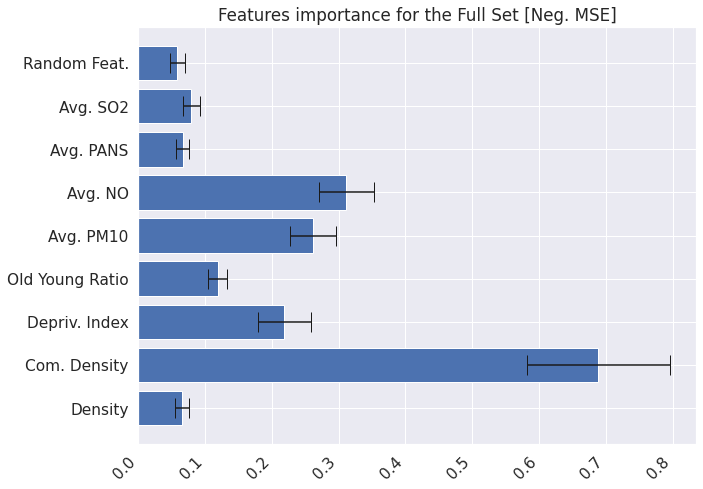

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02992 +/- 0.00447
Feature:                   Com. Density, Score: 0.31519 +/- 0.04899
Feature:                  Depriv. Index, Score: 0.10008 +/- 0.01797
Feature:                Old Young Ratio, Score: 0.05433 +/- 0.00672
Feature:                      Avg. PM10, Score: 0.11974 +/- 0.01588
Feature:                        Avg. NO, Score: 0.14248 +/- 0.01873
Feature:                      Avg. PANS, Score: 0.03043 +/- 0.00445
Feature:                       Avg. SO2, Score: 0.03642 +/- 0.00589


<Figure size 432x288 with 0 Axes>

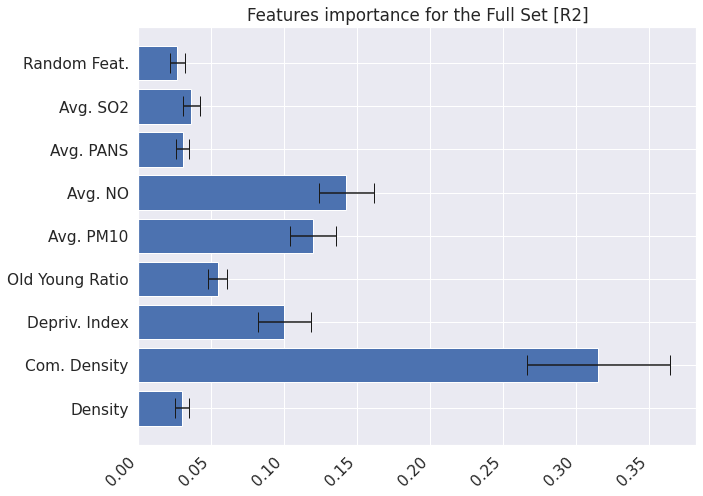

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.56049
                       R2:    0.86317


<Figure size 432x288 with 0 Axes>

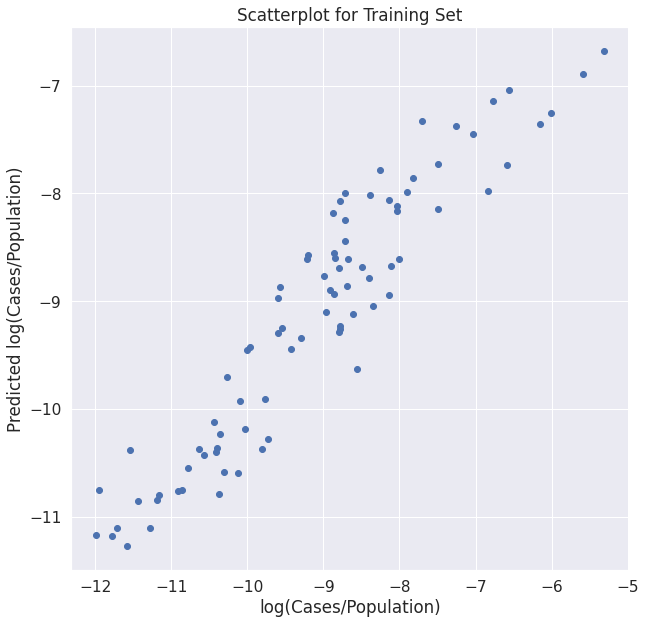

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.88796
                       R2:    0.43248


<Figure size 432x288 with 0 Axes>

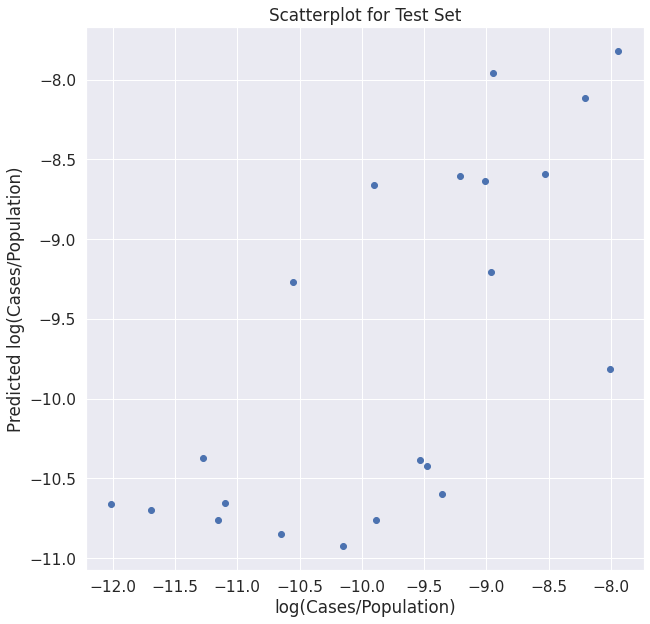

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.17946 +/- 0.17014
Feature:                  Depriv. Index, Score: 0.09674 +/- 0.06359
Feature:                Old Young Ratio, Score: 0.05379 +/- 0.03704
Feature:                      Avg. PANS, Score: 0.08183 +/- 0.05750


<Figure size 432x288 with 0 Axes>

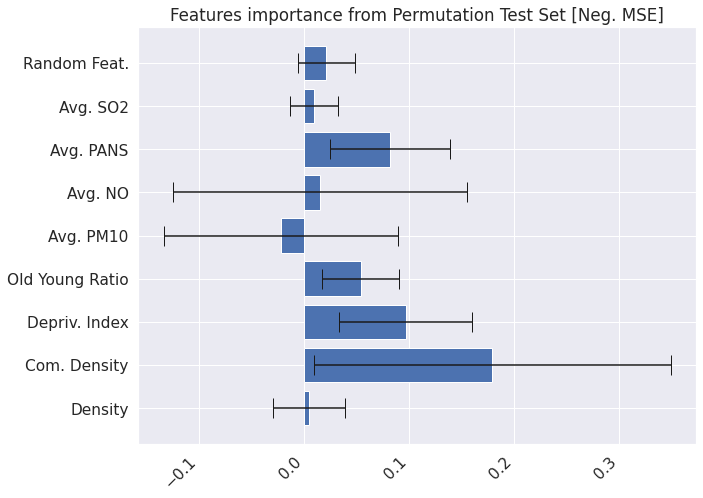

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.12917 +/- 0.12246
Feature:                  Depriv. Index, Score: 0.06963 +/- 0.04577
Feature:                Old Young Ratio, Score: 0.03872 +/- 0.02666
Feature:                      Avg. PANS, Score: 0.05890 +/- 0.04138


<Figure size 432x288 with 0 Axes>

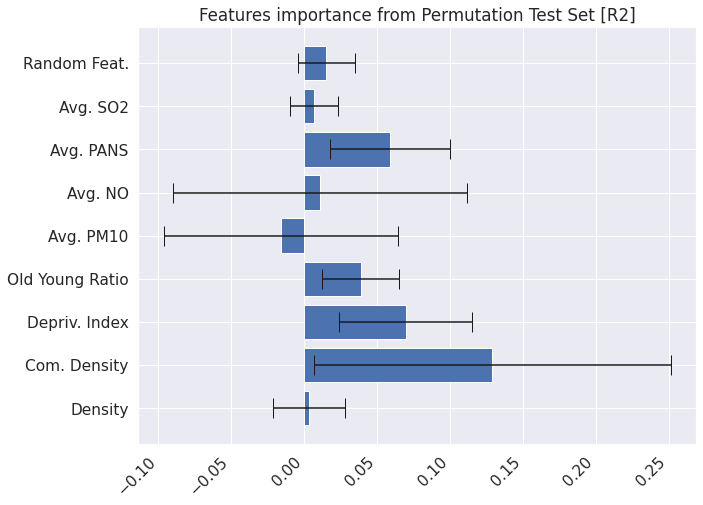

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.60094 +/- 0.10439
Feature:                  Depriv. Index, Score: 0.15697 +/- 0.02973
Feature:                Old Young Ratio, Score: 0.09771 +/- 0.01886
Feature:                      Avg. PM10, Score: 0.41122 +/- 0.08192
Feature:                        Avg. NO, Score: 0.37550 +/- 0.06227
Feature:                      Avg. PANS, Score: 0.08183 +/- 0.01507
Feature:                       Avg. SO2, Score: 0.08333 +/- 0.01208


<Figure size 432x288 with 0 Axes>

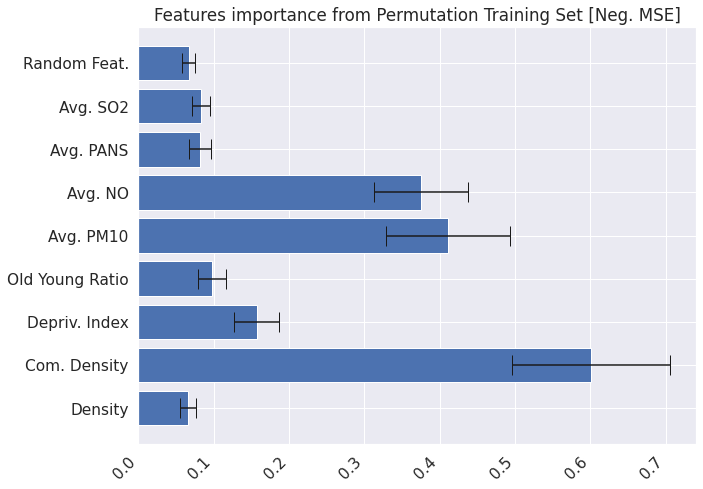

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.26173 +/- 0.04546
Feature:                  Depriv. Index, Score: 0.06837 +/- 0.01295
Feature:                Old Young Ratio, Score: 0.04256 +/- 0.00822
Feature:                      Avg. PM10, Score: 0.17910 +/- 0.03568
Feature:                        Avg. NO, Score: 0.16355 +/- 0.02712
Feature:                      Avg. PANS, Score: 0.03564 +/- 0.00656
Feature:                       Avg. SO2, Score: 0.03629 +/- 0.00526


<Figure size 432x288 with 0 Axes>

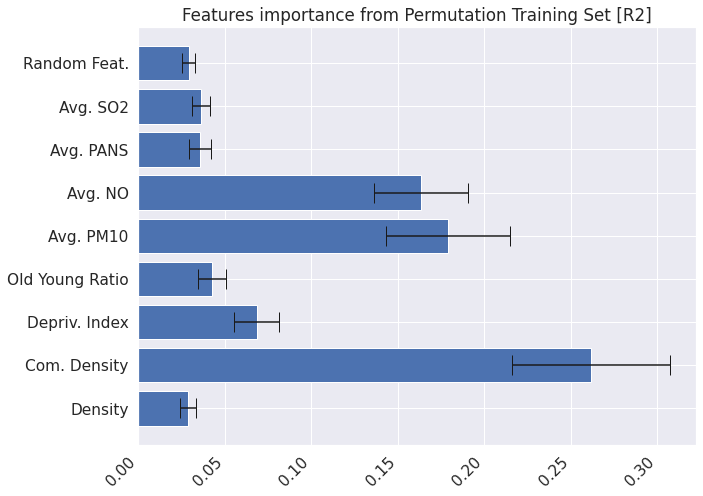

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.75901  0.05054 
    Test set average RMSE:  1.10528  0.10344 

Prediction STD :    1.09024
True value STD :    1.47826
Difference in percentage:   26.24867

             Fullset RMSE:    0.70966
                       R2:    0.76954


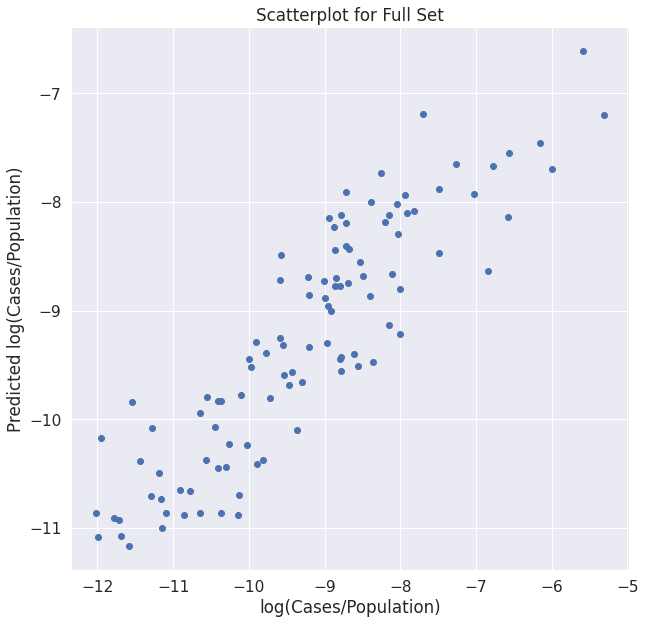

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.63163 +/- 0.10330
Feature:                Old Young Ratio, Score: 0.10370 +/- 0.02154
Feature:                      Avg. PM10, Score: 0.34320 +/- 0.04996
Feature:                        Avg. NO, Score: 0.67832 +/- 0.10200
Feature:                      Avg. PANS, Score: 0.08707 +/- 0.01474
Feature:                       Avg. SO2, Score: 0.07836 +/- 0.01440


<Figure size 432x288 with 0 Axes>

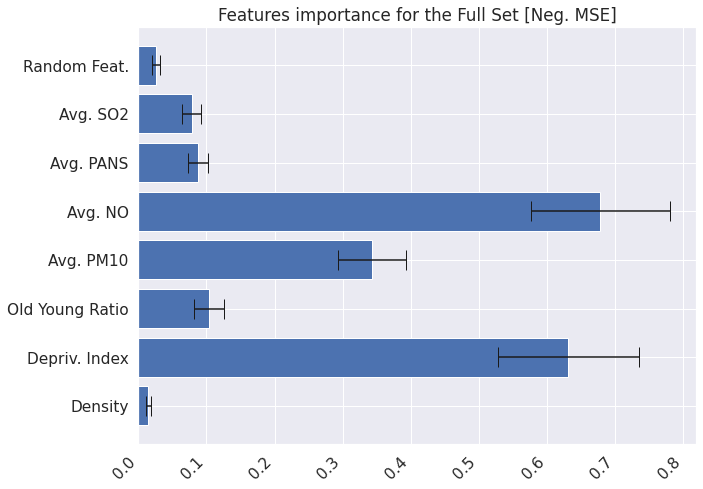

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                  Depriv. Index, Score: 0.28904 +/- 0.04727
Feature:                Old Young Ratio, Score: 0.04745 +/- 0.00986
Feature:                      Avg. PM10, Score: 0.15705 +/- 0.02286
Feature:                        Avg. NO, Score: 0.31041 +/- 0.04668
Feature:                      Avg. PANS, Score: 0.03984 +/- 0.00675
Feature:                       Avg. SO2, Score: 0.03586 +/- 0.00659


<Figure size 432x288 with 0 Axes>

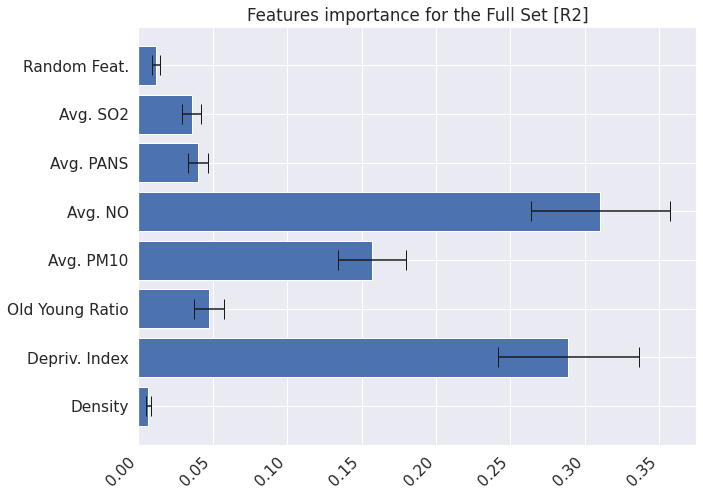

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.74947
                       R2:    0.75536


<Figure size 432x288 with 0 Axes>

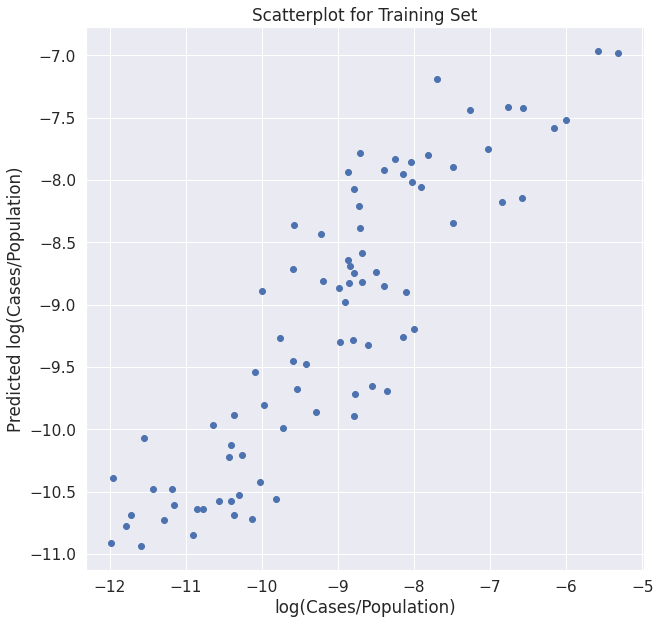

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.96000
                       R2:    0.33667


<Figure size 432x288 with 0 Axes>

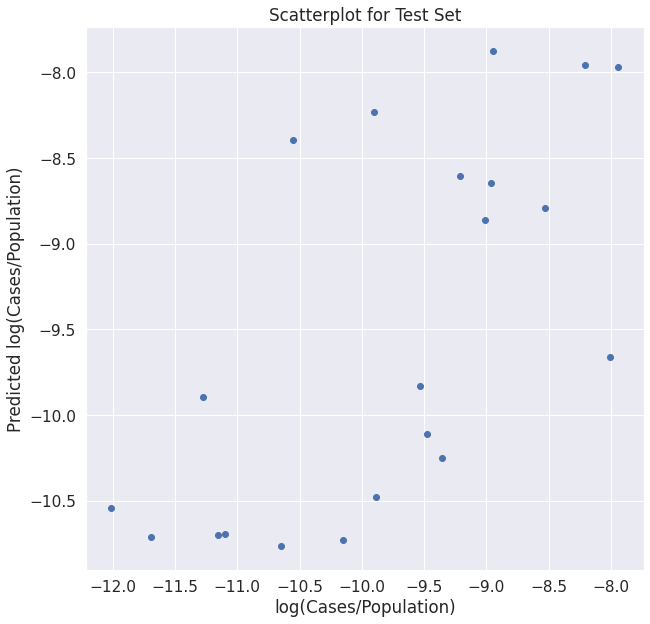

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.17815 +/- 0.09267
Feature:                Old Young Ratio, Score: 0.11296 +/- 0.07247
Feature:                      Avg. PM10, Score: 0.17429 +/- 0.18544
Feature:                        Avg. NO, Score: 0.35281 +/- 0.22554
Feature:                      Avg. PANS, Score: 0.03771 +/- 0.03906
Feature:                       Avg. SO2, Score: 0.04705 +/- 0.03559


<Figure size 432x288 with 0 Axes>

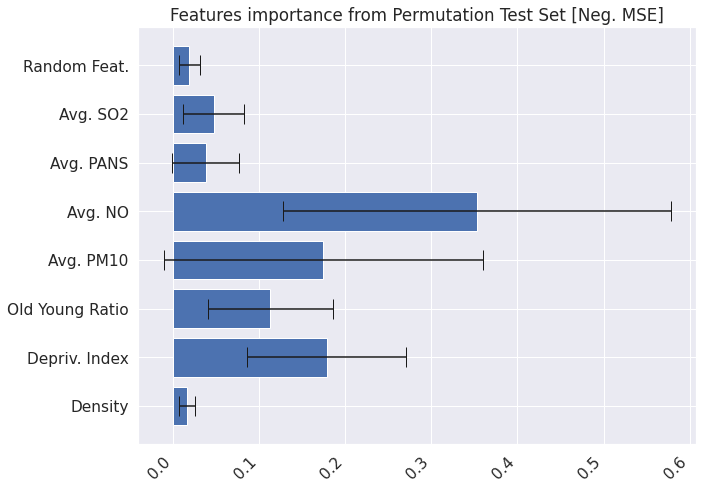

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.12822 +/- 0.06670
Feature:                Old Young Ratio, Score: 0.08130 +/- 0.05216
Feature:                      Avg. PM10, Score: 0.12545 +/- 0.13348
Feature:                        Avg. NO, Score: 0.25394 +/- 0.16234
Feature:                      Avg. PANS, Score: 0.02714 +/- 0.02811
Feature:                       Avg. SO2, Score: 0.03387 +/- 0.02562


<Figure size 432x288 with 0 Axes>

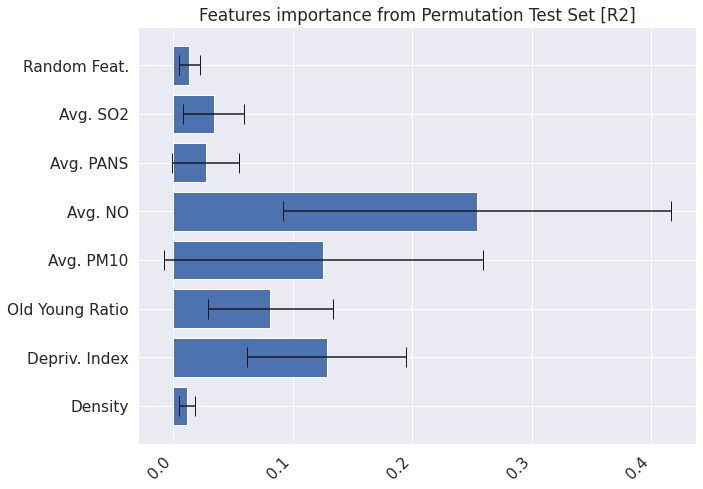

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.20074 +/- 0.04644
Feature:                Old Young Ratio, Score: 0.08601 +/- 0.02252
Feature:                      Avg. PM10, Score: 0.76251 +/- 0.15477
Feature:                        Avg. NO, Score: 0.73849 +/- 0.14563
Feature:                      Avg. PANS, Score: 0.06750 +/- 0.01671
Feature:                       Avg. SO2, Score: 0.11503 +/- 0.01747


<Figure size 432x288 with 0 Axes>

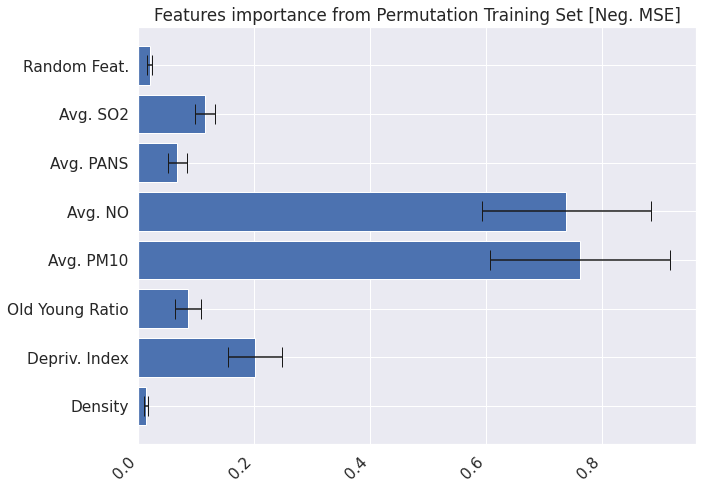

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.08743 +/- 0.02023
Feature:                Old Young Ratio, Score: 0.03746 +/- 0.00981
Feature:                      Avg. PM10, Score: 0.33211 +/- 0.06741
Feature:                        Avg. NO, Score: 0.32164 +/- 0.06343
Feature:                      Avg. PANS, Score: 0.02940 +/- 0.00728
Feature:                       Avg. SO2, Score: 0.05010 +/- 0.00761


<Figure size 432x288 with 0 Axes>

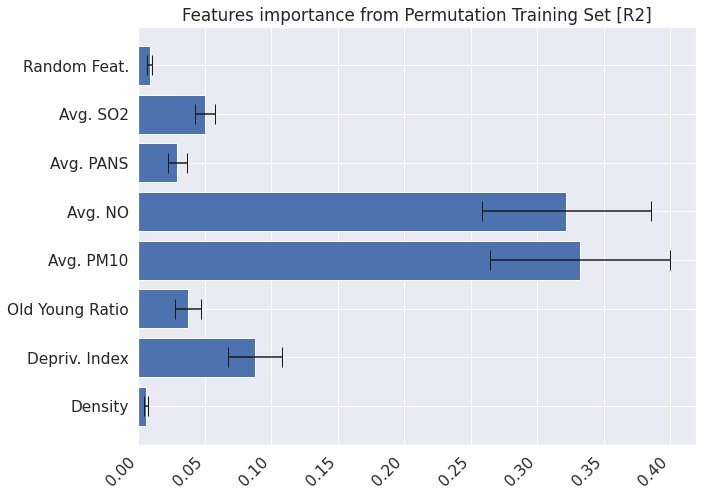

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [29]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...


In [ ]:
featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=100, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=5)